In [1]:
import networkx as nx
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score

import numpy as np
import pandas as pd
from datetime import datetime

from collections import Counter
import itertools

from math import comb, ceil
import random
import string

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import multiprocessing as mp

import pickle

In [2]:
def init_association_matrix(belief_network, propositions = ['A','B','C','D']):
    
    propositions_w_sign = ["+"+p for p in propositions] + ["-"+p for p in propositions] # add the signs

    propositions_w_sign = sorted(propositions_w_sign, key=lambda x: x[1]) # sort by proposition, not sign

    association_matrix = pd.DataFrame(index=propositions_w_sign,  # create the association matrix
                                      columns=propositions_w_sign).fillna(0)

    for e in belief_network.edges(): # fill up 
        for s in [*itertools.product(['+','-'],['+','-'])]:
            association_matrix[f'{s[0]}{e[0]}'][f'{s[1]}{e[1]}'] = 1
            association_matrix[f'{s[0]}{e[1]}'][f'{s[1]}{e[0]}'] = 1

    return association_matrix

In [3]:
def init_beliefs(propositions):
    
    beliefs = np.random.uniform(-1, 1, size=len(propositions))
    beliefs = {e:b for e,b in zip(sorted(propositions), beliefs)}
    
    return beliefs

In [4]:
def bayesian(e1, e2, association_matrix):
    
    evidence = association_matrix[f'-{e2[1]}'].sum() + association_matrix[f'+{e2[1]}'].sum()
    joint_1 = association_matrix[f'+{e2[1]}'][f'+{e1[1]}'] + association_matrix[f'-{e2[1]}'][f'-{e1[1]}']
    joint_2 = association_matrix[f'-{e2[1]}'][f'+{e1[1]}'] + association_matrix[f'+{e2[1]}'][f'-{e1[1]}']
    
    likelihood_pos_rel = joint_1/evidence
    likelihood_neg_rel = joint_2/evidence
    
    return likelihood_pos_rel, likelihood_neg_rel

In [5]:
def infer_relationship(message_to_convey, association_matrix):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    likelihood_pos_rel, likelihood_neg_rel = bayesian(e1, e2, association_matrix)
    
    if likelihood_pos_rel > likelihood_neg_rel:
        return 1
    else:
        return -1

In [6]:
def energy(message_to_convey, beliefs, relationship):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    return - beliefs[e1[1]]*beliefs[e2[1]]*relationship

In [47]:
def energy_comprehensive(message_to_convey, beliefs, association_matrix, belief_network):
    
    energy_sum = 0

    e2 = message_to_convey['e2']
    neighbors = [*belief_network.neighbors(e2[1])]

    for e1 in neighbors:

        relationship = infer_relationship(message_to_convey = message_to_convey, 
                                          association_matrix = association_matrix)

        e = energy(message_to_convey = message_to_convey, beliefs = beliefs, relationship = relationship)

        denominator = association_matrix[f"-{e2[1]}"].sum() + association_matrix[f"+{e2[1]}"].sum()
        nominator = association_matrix[f"-{e2[1]}"][f"-{e1}"].sum() + association_matrix[f"+{e2[1]}"][f"-{e1}"].sum() + association_matrix[f"-{e2[1]}"][f"+{e1}"].sum() + association_matrix[f"+{e2[1]}"][f"+{e1}"].sum()
        weight = nominator / denominator

        energy_sum += e * weight

    return energy_sum

In [49]:
def total_energy(edge_list, agents):

    normalizer = len(edge_list)/2
    internal_energies_all = []

    beliefs = [v['beliefs'] for v in agents.values()]
    association_matrices = [a['association_matrix'] for a in agents.values()]

    for b,a in zip(beliefs,association_matrices):
        internal_energy = 0
        for edge in edge_list:
            message_to_convey = {'e1':f"+{edge[0]}", 'e2':f"+{edge[1]}"}
            relationship = infer_relationship(message_to_convey = message_to_convey, 
                                                association_matrix = a)
            internal_energy += b[edge[0]] *b[edge[1]] * relationship
        
        internal_energies_all.append(internal_energy/normalizer)

    return internal_energies_all

In [9]:
def update_belief(e1, beliefs):
    
    update_term = np.random.normal() # get an update term randomly
    
    beliefs_new = beliefs.copy() # make a copy of beliefs
    
    beliefs_new[e1[1]] = beliefs_new[e1[1]] + update_term # update the belief
    
    if beliefs_new[e1[1]] > 1:
        beliefs_new[e1[1]] = 1
        
    if beliefs_new[e1[1]] < -1:
        beliefs_new[e1[1]] = -1
    
    return beliefs_new

In [11]:
def update_association_matrix(message_to_convey, association_matrix):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    association_matrix[e2][e1] += 1
    association_matrix[e1][e2] += 1

In [12]:
def init_agents(belief_network, n_agents = 2):
    
    propositions = [*belief_network.nodes()]
    
    agents = {}
    
    for a in range(n_agents):
        agents[a] = {}
        agents[a]['association_matrix'] = init_association_matrix(belief_network, propositions)
        agents[a]['beliefs'] = init_beliefs(propositions)
    
    return agents

In [13]:
def deduce_message_to_convey(beliefs_to_convey, agent_beliefs):
    
    message_to_convey = {}
    
    for i, b in enumerate(beliefs_to_convey):
        if np.sign(agent_beliefs[beliefs_to_convey[i]]) == -1:
            message_to_convey[f"e{i+1}"] = f"-{beliefs_to_convey[i]}"
        else:
            message_to_convey[f"e{i+1}"] = f"+{beliefs_to_convey[i]}"
    
    return message_to_convey

In [14]:
def optimal_clustering(beliefs, n_agents):
    
    silhouettes = []
    n_clusters = [*range(2,n_agents)]

    for k in n_clusters:
        clustering = KMeans(n_clusters=k, n_init = 'auto').fit(beliefs)
        silhouettes.append(silhouette_score(beliefs, clustering.labels_))
    
    return n_clusters[np.argmax(silhouettes)], silhouettes[np.argmax(silhouettes)]

def evaluatory_agreement(beliefs):
    
    pref_corr = pd.DataFrame(beliefs).T.corr()
    pref_corr = pref_corr.to_numpy()
    pref_corr = pref_corr[np.triu_indices_from(pref_corr, k=1)]
    
    return pref_corr

def interpretative_agreement(propositions, agents):
    
    proposition_combinations = [*itertools.combinations(propositions, 2)]

    posteriors_all = []
    for matrix in [v['association_matrix'] for v in agents.values()]:
        posteriors = []
        for p1, p2 in proposition_combinations:
            posterior_pos, posterior_neg = bayesian(f'+{p1}', f'+{p2}', matrix)
            posteriors.append(posterior_pos)
            posteriors.append(posterior_neg)

        posteriors_all.append(posteriors)

    interpretative_dist = pairwise_distances(np.array(posteriors_all), metric='euclidean')

    interpretative_dist = interpretative_dist[np.triu_indices_from(interpretative_dist, k=1)]
    
    return interpretative_dist

# Create Belief Networks

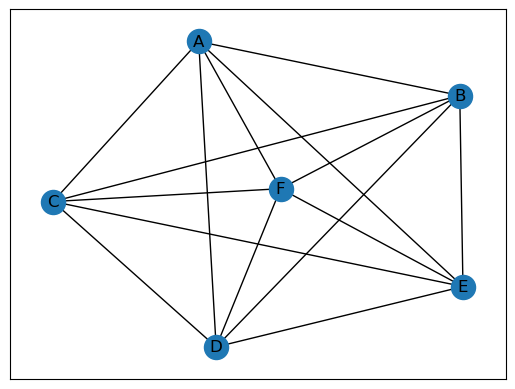

In [15]:
n_beliefs = 6
m = comb(n_beliefs,2)

is_connected = False # initialize the belief network
while is_connected == False:
    bn1 = nx.gnm_random_graph(n=n_beliefs, m = m)
    if nx.number_of_selfloops(bn1) == 0:
        is_connected = nx.is_connected(bn1)

propositions = list(string.ascii_uppercase[:n_beliefs]) # get the proposition names from the alphabet

bn1 = nx.relabel_nodes(bn1, {n:propositions[n] for n in bn1.nodes()}) # relabel the nodes with letters from the alphabet

nx.draw_networkx(bn1) # draw the belief network

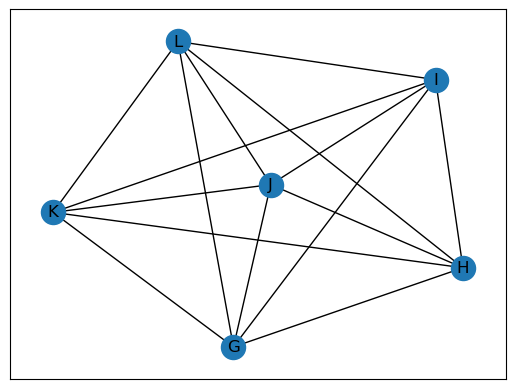

In [16]:
bn2 = bn1.copy()
bn2 = nx.relabel_nodes(bn2,{l1:l2 for l1,l2 in zip([*bn1.nodes],string.ascii_uppercase[len(bn1):len(bn1)+len(bn2)])})
nx.draw_networkx(bn2)

#### Compose networks

In [17]:
def compose_networks(bn1, bn2, n_nodes_to_connect = 1, random=False):
    
    edges_to_add = []

    n1 = np.random.choice([*bn1.nodes()])

    for c in range(n_nodes_to_connect):
        pair_exists = True
        while pair_exists:
            if random == False:
                pair = (n1, np.random.choice([*bn2.nodes()]))
            else:
                pair = (np.random.choice([*bn1.nodes()]), np.random.choice([*bn2.nodes()]))
            if pair not in edges_to_add:
                pair_exists = False

        edges_to_add.append(pair)

    bn_composed = nx.compose(bn1,bn2)
    propositions = [*bn_composed.nodes()]

    for edge in edges_to_add:
        bn_composed.add_edge(edge[0], edge[1])

    return bn_composed

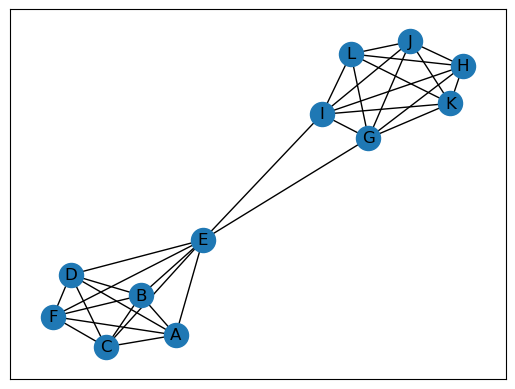

In [18]:
bn_composed = compose_networks(bn1, bn2, n_nodes_to_connect = 2)
nx.draw_networkx(bn_composed)

In [28]:
n_agents = 2

agents = init_agents(bn_composed, n_agents)

edge_list = [*bn_composed.edges()]

total_energy(edge_list, agents)

[0.04387862589085591, 0.06664761452644989]

# Simulation of 2 Agents

In [42]:
n_agents = 2

agents = init_agents(bn_composed, propositions, n_agents)

simulation_steps = [*range(5000)]

for t in simulation_steps:
    
    i = np.random.choice([0,1]) # choose an agent to be the sender
    j = list(set([0,1]) - set([i]))[0] # the other one will be the receiver
    
    b1 = np.random.choice([*bn_composed.nodes()])
    b2 = np.random.choice([*bn_composed.neighbors(b1)])
    beliefs_to_convey = [b1,b2]
    
    message_to_convey = deduce_message_to_convey(beliefs_to_convey, agents[i]['beliefs']) # deduce the message to convey
    update_association_matrix(message_to_convey, agents[j]['association_matrix']) # update receiver's association matrix
    
    relationship = infer_relationship(message_to_convey, association_matrix=agents[j]['association_matrix'])
    
    beliefs_new = update_belief(message_to_convey['e1'], agents[j]['beliefs'])
    
    energy_t = energy_comprehensive(message_to_convey = message_to_convey,
                                    beliefs = agents[j]['beliefs'], 
                                    association_matrix = agents[j]['association_matrix'],
                                    belief_network = bn_composed)
    
    energy_t_plus_1 = energy_comprehensive(message_to_convey = message_to_convey,
                                    beliefs = beliefs_new, 
                                    association_matrix = agents[j]['association_matrix'],
                                    belief_network = bn_composed)
    
    if energy_t_plus_1 < energy_t:
        agents[j]['beliefs'] = beliefs_new

TypeError: init_agents() takes from 1 to 2 positional arguments but 3 were given

In [191]:
((agents[0]['association_matrix']['+F']['+B'].sum()+agents[0]['association_matrix']['-F']['+B'].sum()) + (agents[0]['association_matrix']['+F']['-B'].sum()+agents[0]['association_matrix']['-F']['-B'].sum())) / (agents[0]['association_matrix']['+F'].sum()+agents[0]['association_matrix']['-F'].sum())


0.23414634146341465

In [171]:
message_to_convey = {'e1': '+B', 'e2': '+C'}

energy_comprehensive(message_to_convey = message_to_convey,
                     beliefs = agents[0]['beliefs'], 
                     association_matrix = agents[1]['association_matrix'],
                     belief_network = bn1)

+C
['A', 'F']
A 0.4728682170542636
F 0.5271317829457365


-1.0

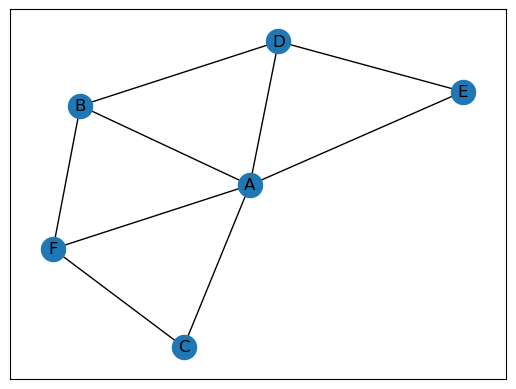

In [166]:
nx.draw_networkx(bn1)

# Simulation of Multiple Agents

In [53]:
def simulate_multiple_agents(bn1, bn2, n_nodes_to_connect):
    
    n_agents = 20

    bn_composed = compose_networks(bn1=bn1, bn2=bn2, n_nodes_to_connect = n_nodes_to_connect)
    propositions = [*bn_composed.nodes()]
    agents = init_agents(bn_composed, n_agents)
    agent_list = [*agents.keys()]
    node_list = [*bn_composed.nodes()]
    edge_list = [*bn_composed.edges()]
    last_step = 2000

    simulation_steps = [*range(last_step+1)]

    track = {}

    for t in tqdm(simulation_steps):
        
        i,j = np.random.choice(agent_list, 2, replace=False) # choose an agent to be the sender and the other one will be the receiver
        
        b1 = np.random.choice(node_list)
        b2 = np.random.choice([*bn_composed.neighbors(b1)])
        beliefs_to_convey = [b1,b2]
        
        message_to_convey = deduce_message_to_convey(beliefs_to_convey, agents[i]['beliefs']) # deduce the message to convey
        update_association_matrix(message_to_convey, agents[j]['association_matrix']) # update receiver's association matrix
        
        relationship = infer_relationship(message_to_convey, association_matrix=agents[j]['association_matrix'])
        
        beliefs_new = update_belief(message_to_convey['e1'], agents[j]['beliefs'])
        
        energy_t = energy_comprehensive(message_to_convey = message_to_convey,
                                        beliefs = agents[j]['beliefs'], 
                                        association_matrix = agents[j]['association_matrix'],
                                        belief_network = bn_composed)
        
        energy_t_plus_1 = energy_comprehensive(message_to_convey = message_to_convey,
                                        beliefs = beliefs_new, 
                                        association_matrix = agents[j]['association_matrix'],
                                        belief_network = bn_composed)

        if energy_t_plus_1 < energy_t:
            agents[j]['beliefs'] = beliefs_new

        # keep track of the evolution of the agents
        if t % 2000 == 0:
            track[t] = {}
            
            beliefs = np.array([[*a['beliefs'].values()] for a in agents.values()])
            
            # Count of unique belief networks
            unique_belief_networks = np.unique(beliefs,axis=0)
            track[t]['count_unique_belief_networks'] = len(unique_belief_networks)
            
            # Number of clusters
            cluster_count, silhouette = optimal_clustering(beliefs, n_agents)
            track[t]['cluster_count'] = cluster_count
            track[t]['silhouette_score'] = silhouette
            
            # Preference congruence and similarity
            pref_corr = evaluatory_agreement(beliefs)
            track[t]['preference_congruence'] = np.abs(pref_corr).mean()
            track[t]['preference_similarity'] = pref_corr.mean()
            
            # Computing evaluatory agreement
            interpretative_dist = interpretative_agreement(propositions, agents)
            track[t]['interpretative_dist'] = np.mean(interpretative_dist)

            # Internal energies
            internal_energy = total_energy(edge_list, agents)
            track[t]['internal_energy'] = np.mean(internal_energy)

            # Stop if everybody has either -1 or +1 only
            #if len(np.unique(unique_belief_networks))==2:
            #    track[t]['belief_networks'] = beliefs
            #    break

            if t == last_step:
                track[t]['belief_networks'] = beliefs
    
    return track

In [44]:
max_nodes_to_connect = 1
repetition = 2

n_nodes_to_connect = list(np.array([[i]*repetition for i in range(1,max_nodes_to_connect+1)]).flatten())

simulation_count = repetition * len(np.unique(n_nodes_to_connect))

params = [*zip([bn1] * simulation_count, [bn2] * simulation_count, n_nodes_to_connect)]

In [51]:
pool = mp.Pool(processes=32)
results = pool.starmap(simulate_multiple_agents, params)
pool.close()

now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

#with open(f'../data/results_{dt_string}.pkl', 'wb') as f:
#    pickle.dump(results, f)

  0%|          | 0/2001 [00:00<?, ?it/s]

{'e1': '+K', 'e2': '-H'}


  0%|          | 0/2001 [00:00<?, ?it/s]

{'e1': '+K', 'e2': '-H'}


  0%|          | 1/2001 [00:00<09:14,  3.61it/s]

{'e1': '+H', 'e2': '-K'}
{'e1': '+B', 'e2': '-F'}


  0%|          | 1/2001 [00:00<09:14,  3.60it/s]

{'e1': '+J', 'e2': '+G'}{'e1': '+H', 'e2': '-K'}

{'e1': '+K', 'e2': '+G'}{'e1': '+B', 'e2': '-F'}

{'e1': '+G', 'e2': '-L'}{'e1': '+J', 'e2': '+G'}

{'e1': '+K', 'e2': '-H'}{'e1': '+K', 'e2': '+G'}

{'e1': '+J', 'e2': '+I'}{'e1': '+G', 'e2': '-L'}

{'e1': '-K', 'e2': '+L'}{'e1': '+K', 'e2': '-H'}

{'e1': '+J', 'e2': '+I'}{'e1': '-L', 'e2': '+J'}

{'e1': '-K', 'e2': '+L'}{'e1': '-K', 'e2': '-I'}

{'e1': '-L', 'e2': '+J'}{'e1': '-L', 'e2': '-I'}

{'e1': '-K', 'e2': '-I'}{'e1': '+A', 'e2': '-G'}

{'e1': '-L', 'e2': '-I'}{'e1': '-E', 'e2': '-C'}

{'e1': '+A', 'e2': '-G'}{'e1': '-E', 'e2': '-A'}

{'e1': '-E', 'e2': '-C'}{'e1': '+L', 'e2': '-I'}

{'e1': '-E', 'e2': '-A'}{'e1': '-L', 'e2': '-I'}

{'e1': '+L', 'e2': '-I'}
{'e1': '-A', 'e2': '+G'}{'e1': '-L', 'e2': '-I'}

{'e1': '+G', 'e2': '+H'}{'e1': '-A', 'e2': '+G'}



  1%|          | 18/2001 [00:00<00:33, 59.88it/s]

{'e1': '-H', 'e2': '+K'}{'e1': '+G', 'e2': '+H'}

{'e1': '+C', 'e2': '+D'}{'e1': '-H', 'e2': '+K'}

{'e1': '+K', 'e2': '+L'}{'e1': '+C', 'e2': '+D'}

{'e1': '+B', 'e2': '+F'}{'e1': '+K', 'e2': '+L'}

{'e1': '+J', 'e2': '-L'}{'e1': '+B', 'e2': '+F'}

{'e1': '-E', 'e2': '+F'}{'e1': '+J', 'e2': '-L'}

{'e1': '-E', 'e2': '+D'}{'e1': '-E', 'e2': '+F'}

{'e1': '+A', 'e2': '-F'}{'e1': '-E', 'e2': '+D'}

{'e1': '-D', 'e2': '-C'}{'e1': '+A', 'e2': '-F'}

{'e1': '-I', 'e2': '+L'}{'e1': '-D', 'e2': '-C'}

{'e1': '-F', 'e2': '-D'}{'e1': '-I', 'e2': '+L'}

{'e1': '-B', 'e2': '-E'}{'e1': '-F', 'e2': '-D'}

{'e1': '+A', 'e2': '-D'}{'e1': '-B', 'e2': '-E'}

{'e1': '-E', 'e2': '+A'}{'e1': '+A', 'e2': '-D'}

{'e1': '+E', 'e2': '+F'}{'e1': '-E', 'e2': '+A'}

{'e1': '-F', 'e2': '-E'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-K', 'e2': '+I'}
{'e1': '-F', 'e2': '-E'}
{'e1': '+F', 'e2': '-D'}
{'e1': '-K', 'e2': '+I'}{'e1': '-L', 'e2': '+J'}

{'e1': '+F', 'e2': '-D'}
{'e1': '-K', 'e2': '+I'}
{'e1': '-L', 'e2': '+J'}


  2%|▏         | 40/2001 [00:00<00:17, 109.93it/s]


{'e1': '-E', 'e2': '+F'}


  2%|▏         | 39/2001 [00:00<00:18, 108.10it/s]

{'e1': '+H', 'e2': '-L'}{'e1': '-E', 'e2': '+F'}

{'e1': '-E', 'e2': '+F'}{'e1': '-C', 'e2': '-D'}

{'e1': '-E', 'e2': '+F'}
{'e1': '-A', 'e2': '+F'}
{'e1': '-C', 'e2': '-D'}
{'e1': '+G', 'e2': '-J'}
{'e1': '-A', 'e2': '+F'}
{'e1': '+G', 'e2': '+K'}
{'e1': '+G', 'e2': '-J'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+G', 'e2': '+K'}
{'e1': '+I', 'e2': '+J'}
{'e1': '-G', 'e2': '+I'}
{'e1': '-F', 'e2': '+C'}
{'e1': '+I', 'e2': '+J'}
{'e1': '+L', 'e2': '+H'}
{'e1': '-F', 'e2': '+C'}
{'e1': '+F', 'e2': '-C'}
{'e1': '+L', 'e2': '+H'}
{'e1': '-E', 'e2': '+D'}
{'e1': '+F', 'e2': '-C'}
{'e1': '+J', 'e2': '-L'}
{'e1': '-E', 'e2': '+D'}
{'e1': '+F', 'e2': '-E'}
{'e1': '+J', 'e2': '-L'}
{'e1': '-H', 'e2': '-I'}
{'e1': '+F', 'e2': '-E'}
{'e1': '+F', 'e2': '+E'}
{'e1': '-H', 'e2': '-I'}
{'e1': '-G', 'e2': '+A'}
{'e1': '+F', 'e2': '+E'}
{'e1': '+L', 'e2': '-J'}
{'e1': '-G', 'e2': '+A'}
{'e1': '-K', 'e2': '+G'}
{'e1': '+L', 'e2': '-J'}
{'e1': '+H', 'e2': '-L'}
{'e1': '-K', 'e2': '+G'}
{'e1': '-B', 'e2': '-A'}


  4%|▎         | 73/2001 [00:00<00:10, 178.07it/s]

{'e1': '+C', 'e2': '+F'}

  4%|▎         | 72/2001 [00:00<00:10, 177.76it/s]


{'e1': '+I', 'e2': '+L'}
{'e1': '+I', 'e2': '+K'}
{'e1': '+C', 'e2': '+F'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+I', 'e2': '+K'}
{'e1': '+G', 'e2': '+A'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+I', 'e2': '-J'}
{'e1': '+G', 'e2': '+A'}
{'e1': '-H', 'e2': '+K'}
{'e1': '+I', 'e2': '-J'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-H', 'e2': '+K'}
{'e1': '+K', 'e2': '+J'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-J', 'e2': '-K'}
{'e1': '+K', 'e2': '+J'}
{'e1': '+K', 'e2': '+L'}
{'e1': '-J', 'e2': '-K'}
{'e1': '-D', 'e2': '-B'}
{'e1': '+K', 'e2': '+L'}
{'e1': '-C', 'e2': '-F'}
{'e1': '-D', 'e2': '-B'}
{'e1': '+L', 'e2': '+H'}
{'e1': '-C', 'e2': '-F'}
{'e1': '+K', 'e2': '+L'}
{'e1': '+L', 'e2': '+H'}
{'e1': '-L', 'e2': '-H'}
{'e1': '+K', 'e2': '+L'}
{'e1': '-B', 'e2': '-D'}
{'e1': '-L', 'e2': '-H'}
{'e1': '+G', 'e2': '+H'}
{'e1': '-B', 'e2': '-D'}
{'e1': '-A', 'e2': '+F'}
{'e1': '+G', 'e2': '+H'}
{'e1': '-H', 'e2': '-J'}
{'e1': '-A', 'e2': '+F'}
{'e1': '-I', 'e2': '-L'}{'e1': '-H', 'e2': '-J'}

{'e1': '+G', 'e2': '+K'}

  5%|▌         | 107/2001 [00:00<00:08, 228.09it/s]


{'e1': '-B', 'e2': '-A'}


  5%|▌         | 107/2001 [00:00<00:08, 230.27it/s]

{'e1': '-B', 'e2': '-A'}{'e1': '+C', 'e2': '+D'}

{'e1': '+C', 'e2': '+D'}
{'e1': '+J', 'e2': '-K'}
{'e1': '+J', 'e2': '-K'}
{'e1': '+K', 'e2': '-G'}
{'e1': '+K', 'e2': '-G'}
{'e1': '-D', 'e2': '-E'}
{'e1': '-D', 'e2': '-E'}
{'e1': '+F', 'e2': '-A'}
{'e1': '+F', 'e2': '-A'}
{'e1': '+L', 'e2': '+I'}
{'e1': '+L', 'e2': '+I'}
{'e1': '+I', 'e2': '+K'}
{'e1': '+I', 'e2': '+K'}
{'e1': '+J', 'e2': '-G'}
{'e1': '+J', 'e2': '-G'}
{'e1': '-L', 'e2': '+J'}
{'e1': '-L', 'e2': '+J'}
{'e1': '-I', 'e2': '-H'}
{'e1': '-I', 'e2': '-H'}
{'e1': '+G', 'e2': '+J'}
{'e1': '+G', 'e2': '+J'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-D', 'e2': '-A'}
{'e1': '+I', 'e2': '+K'}
{'e1': '+I', 'e2': '+K'}
{'e1': '-K', 'e2': '-J'}
{'e1': '-K', 'e2': '-J'}
{'e1': '+G', 'e2': '+I'}
{'e1': '+G', 'e2': '+I'}
{'e1': '+H', 'e2': '+J'}
{'e1': '+H', 'e2': '+J'}
{'e1': '+C', 'e2': '-F'}
{'e1': '+C', 'e2': '-F'}
{'e1': '+K', 'e2': '-I'}
{'e1': '+K', 'e2': '-I'}
{'e1': '+E', 'e2': '-B'}
{'e1': '+E', 'e2': '-B'}
{'e1': '-A', 'e2': '+B'}


  7%|▋         | 141/2001 [00:00<00:07, 260.66it/s]

{'e1': '-G', 'e2': '+L'}

  7%|▋         | 141/2001 [00:00<00:07, 262.83it/s]


{'e1': '-G', 'e2': '+L'}
{'e1': '-A', 'e2': '+D'}
{'e1': '-A', 'e2': '+D'}
{'e1': '-D', 'e2': '-B'}
{'e1': '-D', 'e2': '-B'}
{'e1': '+L', 'e2': '+H'}
{'e1': '+L', 'e2': '+H'}
{'e1': '+C', 'e2': '-B'}
{'e1': '+C', 'e2': '-B'}
{'e1': '-L', 'e2': '-H'}
{'e1': '-L', 'e2': '-H'}
{'e1': '-K', 'e2': '-L'}{'e1': '-K', 'e2': '-L'}

{'e1': '+A', 'e2': '-D'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-K', 'e2': '+J'}{'e1': '-K', 'e2': '+J'}

{'e1': '-E', 'e2': '+A'}{'e1': '-E', 'e2': '+A'}

{'e1': '-J', 'e2': '+G'}{'e1': '-J', 'e2': '+G'}

{'e1': '+C', 'e2': '+E'}{'e1': '+C', 'e2': '+E'}

{'e1': '+I', 'e2': '-J'}{'e1': '+I', 'e2': '-J'}

{'e1': '+K', 'e2': '-J'}
{'e1': '+K', 'e2': '-J'}
{'e1': '+J', 'e2': '-I'}
{'e1': '+J', 'e2': '-I'}
{'e1': '+C', 'e2': '-E'}
{'e1': '+C', 'e2': '-E'}
{'e1': '-A', 'e2': '+F'}
{'e1': '-A', 'e2': '+F'}
{'e1': '+E', 'e2': '-B'}
{'e1': '+E', 'e2': '-B'}
{'e1': '-B', 'e2': '+A'}
{'e1': '-B', 'e2': '+A'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-J', 'e2': '-K'}

  9%|▊         | 175/2001 [00:00<00:06, 285.05it/s]

{'e1': '-K', 'e2': '+G'}{'e1': '-K', 'e2': '+G'}

{'e1': '-D', 'e2': '-C'}{'e1': '-D', 'e2': '-C'}

{'e1': '+I', 'e2': '+K'}
{'e1': '+I', 'e2': '+K'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+L', 'e2': '+J'}{'e1': '+L', 'e2': '+J'}

{'e1': '+H', 'e2': '-L'}{'e1': '+H', 'e2': '-L'}

{'e1': '-J', 'e2': '+H'}{'e1': '-J', 'e2': '+H'}

{'e1': '-D', 'e2': '+A'}
{'e1': '-D', 'e2': '+A'}
{'e1': '-H', 'e2': '-L'}{'e1': '-H', 'e2': '-L'}

{'e1': '-H', 'e2': '-G'}{'e1': '-H', 'e2': '-G'}

{'e1': '-C', 'e2': '+F'}{'e1': '-C', 'e2': '+F'}

{'e1': '+I', 'e2': '+K'}{'e1': '+I', 'e2': '+K'}

{'e1': '+C', 'e2': '+E'}
{'e1': '+C', 'e2': '+E'}
{'e1': '+H', 'e2': '-I'}
{'e1': '+H', 'e2': '-I'}
{'e1': '+A', 'e2': '+C'}
{'e1': '+A', 'e2': '+C'}
{'e1': '-B', 'e2': '+C'}
{'e1': '-B', 'e2': '+C'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-C', 'e2': '+F'}
{'e1': '+C', 'e2': '+E'}
{'e1': '+C', 'e2': '+E'}
{'e1': '+A', 'e2': '-B'}
{'e1': '+A', 'e2': '-B'}
{'e1': '-J', 'e2': '+G'}
{'e1': '-J', 'e2': '+G'}


 10%|█         | 209/2001 [00:00<00:05, 299.56it/s]

{'e1': '-A', 'e2': '-E'}

 10%|█         | 209/2001 [00:00<00:05, 300.98it/s]


{'e1': '-A', 'e2': '-E'}
{'e1': '-E', 'e2': '+B'}
{'e1': '-E', 'e2': '+B'}
{'e1': '-G', 'e2': '+K'}
{'e1': '-G', 'e2': '+K'}
{'e1': '+A', 'e2': '-C'}
{'e1': '+A', 'e2': '-C'}
{'e1': '-K', 'e2': '-G'}
{'e1': '-K', 'e2': '-G'}
{'e1': '-H', 'e2': '-L'}
{'e1': '-H', 'e2': '-L'}
{'e1': '-K', 'e2': '+J'}
{'e1': '-K', 'e2': '+J'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+B', 'e2': '+F'}
{'e1': '+B', 'e2': '+F'}
{'e1': '-D', 'e2': '-E'}{'e1': '-D', 'e2': '-E'}

{'e1': '+I', 'e2': '+L'}{'e1': '+I', 'e2': '+L'}

{'e1': '+G', 'e2': '-J'}{'e1': '+G', 'e2': '-J'}

{'e1': '+J', 'e2': '-G'}{'e1': '+J', 'e2': '-G'}

{'e1': '+H', 'e2': '-L'}{'e1': '+H', 'e2': '-L'}

{'e1': '-B', 'e2': '+F'}{'e1': '-B', 'e2': '+F'}

{'e1': '+G', 'e2': '+A'}{'e1': '+G', 'e2': '+A'}

{'e1': '-J', 'e2': '-K'}{'e1': '-J', 'e2': '-K'}

{'e1': '+F', 'e2': '+A'}{'e1': '+F', 'e2': '+A'}

{'e1': '+L', 'e2': '+H'}{'e1': '+L', 'e2': '+H'}

{'e1': '-C', 'e2': '+F'}{'e1': '-C', 'e2': '+F'}

{'e1': '-C', 'e2': '+F'}

 12%|█▏        | 242/2001 [00:01<00:05, 307.73it/s]


{'e1': '-I', 'e2': '-L'}


 12%|█▏        | 243/2001 [00:01<00:05, 310.10it/s]

{'e1': '-K', 'e2': '-I'}{'e1': '-K', 'e2': '-I'}

{'e1': '-B', 'e2': '-D'}{'e1': '-B', 'e2': '-D'}

{'e1': '-D', 'e2': '-A'}{'e1': '-D', 'e2': '-A'}

{'e1': '+L', 'e2': '+H'}{'e1': '+L', 'e2': '+H'}

{'e1': '-F', 'e2': '-A'}{'e1': '-F', 'e2': '-A'}

{'e1': '-B', 'e2': '-E'}{'e1': '-B', 'e2': '-E'}

{'e1': '+E', 'e2': '-F'}{'e1': '+E', 'e2': '-F'}

{'e1': '-B', 'e2': '+A'}{'e1': '-B', 'e2': '+A'}

{'e1': '-C', 'e2': '-A'}{'e1': '-C', 'e2': '-A'}

{'e1': '-L', 'e2': '-I'}{'e1': '-L', 'e2': '-I'}

{'e1': '+I', 'e2': '-L'}{'e1': '+I', 'e2': '-L'}

{'e1': '+E', 'e2': '+A'}{'e1': '+E', 'e2': '+A'}

{'e1': '-G', 'e2': '+J'}{'e1': '-G', 'e2': '+J'}

{'e1': '+A', 'e2': '-C'}{'e1': '+A', 'e2': '-C'}

{'e1': '-K', 'e2': '-J'}{'e1': '-K', 'e2': '-J'}

{'e1': '-B', 'e2': '+F'}
{'e1': '-B', 'e2': '+F'}
{'e1': '+E', 'e2': '-B'}
{'e1': '+K', 'e2': '-J'}{'e1': '+E', 'e2': '-B'}

{'e1': '+I', 'e2': '+L'}
{'e1': '+K', 'e2': '-J'}
{'e1': '+B', 'e2': '+F'}
{'e1': '+I', 'e2': '+L'}
{'e1': '-F', 'e2': '+D'}


 14%|█▎        | 274/2001 [00:01<00:05, 310.24it/s]

{'e1': '+K', 'e2': '-L'}{'e1': '-K', 'e2': '+J'}

{'e1': '+L', 'e2': '-I'}{'e1': '+J', 'e2': '-K'}

{'e1': '+L', 'e2': '-K'}{'e1': '+K', 'e2': '-L'}

{'e1': '-B', 'e2': '-A'}


 14%|█▎        | 275/2001 [00:01<00:05, 304.79it/s]

{'e1': '+L', 'e2': '-I'}
{'e1': '-C', 'e2': '-D'}
{'e1': '+L', 'e2': '-K'}{'e1': '+E', 'e2': '+C'}

{'e1': '-B', 'e2': '-A'}{'e1': '-D', 'e2': '+A'}

{'e1': '-C', 'e2': '-D'}{'e1': '-C', 'e2': '+A'}

{'e1': '+E', 'e2': '+C'}{'e1': '+J', 'e2': '+H'}

{'e1': '-D', 'e2': '+A'}{'e1': '-J', 'e2': '+I'}

{'e1': '-C', 'e2': '+A'}{'e1': '+H', 'e2': '-I'}

{'e1': '+K', 'e2': '+H'}{'e1': '+J', 'e2': '+H'}

{'e1': '-C', 'e2': '+F'}{'e1': '-J', 'e2': '+I'}

{'e1': '+G', 'e2': '+H'}{'e1': '+H', 'e2': '-I'}

{'e1': '-J', 'e2': '+H'}
{'e1': '+K', 'e2': '+H'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-I', 'e2': '-K'}
{'e1': '+G', 'e2': '+H'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-J', 'e2': '+H'}
{'e1': '-G', 'e2': '-I'}
{'e1': '+A', 'e2': '-D'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-I', 'e2': '-K'}{'e1': '+H', 'e2': '-K'}

{'e1': '-D', 'e2': '+E'}{'e1': '+B', 'e2': '-A'}

{'e1': '-G', 'e2': '-I'}{'e1': '-B', 'e2': '-E'}

{'e1': '+E', 'e2': '+F'}{'e1': '+B', 'e2': '-F'}

{'e1': '+H', 'e2': '-K'}{

 15%|█▌        | 308/2001 [00:01<00:05, 316.43it/s]

{'e1': '-D', 'e2': '+E'}
{'e1': '-C', 'e2': '-A'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+K', 'e2': '+G'}
{'e1': '-L', 'e2': '-I'}
{'e1': '+A', 'e2': '-D'}{'e1': '+K', 'e2': '+H'}



 15%|█▌        | 307/2001 [00:01<00:05, 305.62it/s]

{'e1': '+C', 'e2': '-D'}{'e1': '+I', 'e2': '+G'}

{'e1': '-A', 'e2': '-F'}
{'e1': '-D', 'e2': '+E'}
{'e1': '+K', 'e2': '-L'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+K', 'e2': '-J'}
{'e1': '-L', 'e2': '-I'}
{'e1': '-E', 'e2': '+D'}
{'e1': '+K', 'e2': '+H'}
{'e1': '-I', 'e2': '-K'}
{'e1': '+C', 'e2': '-D'}
{'e1': '+E', 'e2': '-C'}
{'e1': '-A', 'e2': '-F'}
{'e1': '-G', 'e2': '+H'}
{'e1': '+K', 'e2': '-L'}{'e1': '+H', 'e2': '-L'}

{'e1': '+K', 'e2': '-J'}{'e1': '-D', 'e2': '+E'}

{'e1': '-E', 'e2': '+D'}{'e1': '-I', 'e2': '-K'}

{'e1': '-I', 'e2': '-K'}{'e1': '+H', 'e2': '-L'}

{'e1': '+H', 'e2': '+G'}{'e1': '+E', 'e2': '-C'}

{'e1': '-K', 'e2': '+H'}{'e1': '-G', 'e2': '+H'}

{'e1': '+E', 'e2': '-D'}{'e1': '+H', 'e2': '-L'}

{'e1': '+K', 'e2': '+G'}{'e1': '-D', 'e2': '+E'}

{'e1': '+L', 'e2': '-K'}{'e1': '-I', 'e2': '-K'}

{'e1': '-C', 'e2': '-E'}{'e1': '+H', 'e2': '-L'}

{'e1': '-B', 'e2': '+F'}{'e1': '+H', 'e2': '+G'}

{'e1': '+E', 'e2': '-D'}{'e1': '-K', 'e2': '+H'}

{'e1': '+J', 'e2': '-G'}


 17%|█▋        | 342/2001 [00:01<00:05, 323.25it/s]

{'e1': '-I', 'e2': '-K'}{'e1': '-B', 'e2': '-E'}

{'e1': '-D', 'e2': '+F'}
{'e1': '-A', 'e2': '+C'}
{'e1': '-J', 'e2': '-G'}{'e1': '+F', 'e2': '-E'}

{'e1': '+H', 'e2': '-J'}{'e1': '-J', 'e2': '+H'}

{'e1': '-I', 'e2': '-L'}

 17%|█▋        | 339/2001 [00:01<00:05, 308.64it/s]


{'e1': '-H', 'e2': '+L'}
{'e1': '+C', 'e2': '-B'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+F', 'e2': '-D'}
{'e1': '+G', 'e2': '-J'}
{'e1': '+G', 'e2': '-K'}
{'e1': '-I', 'e2': '-K'}
{'e1': '-L', 'e2': '+H'}
{'e1': '-D', 'e2': '+F'}
{'e1': '+K', 'e2': '+J'}
{'e1': '-J', 'e2': '-G'}
{'e1': '-D', 'e2': '-C'}
{'e1': '+H', 'e2': '-J'}
{'e1': '+E', 'e2': '-B'}
{'e1': '-I', 'e2': '-L'}
{'e1': '+K', 'e2': '-G'}
{'e1': '+C', 'e2': '-B'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+F', 'e2': '-D'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+G', 'e2': '-K'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-L', 'e2': '+H'}
{'e1': '-K', 'e2': '-J'}
{'e1': '+K', 'e2': '+J'}
{'e1': '-A', 'e2': '-D'}
{'e1': '-D', 'e2': '-C'}
{'e1': '+J', 'e2': '-L'}
{'e1': '+E', 'e2': '-B'}
{'e1': '-A', 'e2': '+C'}
{'e1': '+K', 'e2': '-G'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-L', 'e2': '+I'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+B', 'e2': '-C'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-I', 'e2': '+J'}
{'e1': '-K', 'e2': '-J'}
{'e1': '-L', 'e2': '+G'}

 19%|█▉        | 376/2001 [00:01<00:04, 326.68it/s]

{'e1': '-D', 'e2': '-F'}
{'e1': '+K', 'e2': '-G'}
{'e1': '+B', 'e2': '-A'}
{'e1': '-C', 'e2': '+A'}
{'e1': '-B', 'e2': '+E'}
{'e1': '+E', 'e2': '+F'}
{'e1': '+C', 'e2': '+F'}
{'e1': '+A', 'e2': '+G'}
{'e1': '+I', 'e2': '-L'}


 19%|█▊        | 373/2001 [00:01<00:05, 315.30it/s]

{'e1': '+F', 'e2': '-D'}{'e1': '-G', 'e2': '+L'}

{'e1': '+K', 'e2': '+H'}{'e1': '+B', 'e2': '-F'}

{'e1': '+F', 'e2': '-C'}{'e1': '+K', 'e2': '-H'}

{'e1': '+B', 'e2': '+A'}
{'e1': '-D', 'e2': '-F'}
{'e1': '-G', 'e2': '-A'}
{'e1': '+B', 'e2': '-A'}
{'e1': '-B', 'e2': '-E'}
{'e1': '-B', 'e2': '+E'}
{'e1': '-L', 'e2': '+G'}
{'e1': '+C', 'e2': '+F'}
{'e1': '+G', 'e2': '-L'}
{'e1': '+I', 'e2': '-L'}
{'e1': '-I', 'e2': '+G'}
{'e1': '-G', 'e2': '+L'}
{'e1': '-J', 'e2': '-K'}
{'e1': '+B', 'e2': '-F'}
{'e1': '-A', 'e2': '-E'}
{'e1': '+K', 'e2': '-H'}
{'e1': '+B', 'e2': '-A'}
{'e1': '+B', 'e2': '+A'}
{'e1': '-A', 'e2': '+B'}
{'e1': '-G', 'e2': '-A'}
{'e1': '+E', 'e2': '-C'}
{'e1': '-B', 'e2': '-E'}
{'e1': '+H', 'e2': '-G'}
{'e1': '-L', 'e2': '+G'}
{'e1': '+E', 'e2': '-C'}
{'e1': '+G', 'e2': '-L'}{'e1': '+A', 'e2': '-B'}

{'e1': '-I', 'e2': '+G'}{'e1': '-L', 'e2': '+J'}

{'e1': '-J', 'e2': '-K'}{'e1': '-C', 'e2': '-A'}

{'e1': '-A', 'e2': '-E'}{'e1': '+F', 'e2': '-D'}

{'e1': '+B', 'e2': '-A'}{

 20%|██        | 410/2001 [00:01<00:04, 330.21it/s]

{'e1': '-D', 'e2': '-B'}{'e1': '+L', 'e2': '+H'}

{'e1': '+E', 'e2': '+B'}{'e1': '+I', 'e2': '+G'}

{'e1': '-L', 'e2': '+K'}{'e1': '-K', 'e2': '+L'}

{'e1': '+A', 'e2': '+E'}{'e1': '-K', 'e2': '+I'}

{'e1': '-L', 'e2': '-G'}{'e1': '+F', 'e2': '-B'}

{'e1': '-I', 'e2': '-J'}

 20%|██        | 406/2001 [00:01<00:05, 318.02it/s]


{'e1': '+K', 'e2': '-J'}
{'e1': '+C', 'e2': '-A'}
{'e1': '+H', 'e2': '-G'}
{'e1': '-I', 'e2': '-L'}
{'e1': '-E', 'e2': '-D'}
{'e1': '+L', 'e2': '-K'}
{'e1': '-J', 'e2': '+K'}
{'e1': '+G', 'e2': '+J'}
{'e1': '+L', 'e2': '+H'}{'e1': '-K', 'e2': '+G'}

{'e1': '+I', 'e2': '+G'}{'e1': '-K', 'e2': '+J'}

{'e1': '-K', 'e2': '+L'}{'e1': '-G', 'e2': '-L'}

{'e1': '-K', 'e2': '+I'}{'e1': '+K', 'e2': '-L'}

{'e1': '+F', 'e2': '-D'}{'e1': '+F', 'e2': '-B'}

{'e1': '-E', 'e2': '-A'}{'e1': '-I', 'e2': '-J'}

{'e1': '-C', 'e2': '+F'}{'e1': '+C', 'e2': '-A'}

{'e1': '-G', 'e2': '+L'}{'e1': '-I', 'e2': '-L'}

{'e1': '-C', 'e2': '-B'}
{'e1': '+L', 'e2': '-K'}
{'e1': '-C', 'e2': '+A'}
{'e1': '+G', 'e2': '+J'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-K', 'e2': '+G'}
{'e1': '+H', 'e2': '-J'}
{'e1': '-K', 'e2': '+J'}
{'e1': '+F', 'e2': '-B'}
{'e1': '-G', 'e2': '-L'}
{'e1': '-B', 'e2': '+C'}
{'e1': '+K', 'e2': '-L'}
{'e1': '+J', 'e2': '-L'}
{'e1': '+F', 'e2': '-D'}{'e1': '+E', 'e2': '-A'}

{'e1': '-E', 'e2': '-A'}

 22%|██▏       | 444/2001 [00:01<00:04, 333.07it/s]


{'e1': '-F', 'e2': '+B'}
{'e1': '-B', 'e2': '+C'}
{'e1': '-D', 'e2': '+A'}
{'e1': '+J', 'e2': '-L'}
{'e1': '+B', 'e2': '-A'}
{'e1': '+E', 'e2': '-A'}
{'e1': '-D', 'e2': '-E'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-B', 'e2': '+E'}
{'e1': '+C', 'e2': '-A'}
{'e1': '+E', 'e2': '-C'}


 22%|██▏       | 438/2001 [00:01<00:04, 316.68it/s]

{'e1': '-F', 'e2': '-D'}{'e1': '+B', 'e2': '+F'}

{'e1': '-C', 'e2': '+E'}{'e1': '-I', 'e2': '+J'}

{'e1': '-G', 'e2': '+J'}{'e1': '-I', 'e2': '+J'}

{'e1': '-I', 'e2': '+H'}{'e1': '+J', 'e2': '+H'}

{'e1': '-C', 'e2': '+E'}{'e1': '-G', 'e2': '+H'}

{'e1': '-A', 'e2': '-F'}
{'e1': '+I', 'e2': '-J'}
{'e1': '-B', 'e2': '+E'}
{'e1': '-F', 'e2': '+B'}
{'e1': '+K', 'e2': '+G'}
{'e1': '-D', 'e2': '+A'}
{'e1': '+G', 'e2': '+I'}
{'e1': '+B', 'e2': '-A'}
{'e1': '-B', 'e2': '+D'}
{'e1': '-D', 'e2': '-E'}
{'e1': '-A', 'e2': '+D'}
{'e1': '-B', 'e2': '+E'}{'e1': '+I', 'e2': '+L'}

{'e1': '+E', 'e2': '-C'}{'e1': '-F', 'e2': '-B'}

{'e1': '+B', 'e2': '+F'}{'e1': '-H', 'e2': '-J'}

{'e1': '-I', 'e2': '+J'}{'e1': '+I', 'e2': '+K'}

{'e1': '-I', 'e2': '+J'}{'e1': '+B', 'e2': '+C'}

{'e1': '-I', 'e2': '+H'}{'e1': '-C', 'e2': '-E'}

{'e1': '-C', 'e2': '+E'}{'e1': '+J', 'e2': '+L'}

{'e1': '-A', 'e2': '-F'}{'e1': '+F', 'e2': '-A'}

{'e1': '-B', 'e2': '+E'}{'e1': '+A', 'e2': '-C'}

{'e1': '+K', 'e2': '+G'}{

 24%|██▍       | 478/2001 [00:01<00:04, 334.82it/s]

{'e1': '-A', 'e2': '-D'}{'e1': '+B', 'e2': '+C'}
{'e1': '-D', 'e2': '+B'}

{'e1': '-C', 'e2': '-E'}{'e1': '+F', 'e2': '-C'}

{'e1': '+J', 'e2': '+L'}{'e1': '+F', 'e2': '+E'}

{'e1': '-F', 'e2': '+A'}{'e1': '+F', 'e2': '-A'}

{'e1': '+K', 'e2': '-L'}{'e1': '+A', 'e2': '-C'}

{'e1': '-C', 'e2': '-D'}


 23%|██▎       | 470/2001 [00:01<00:04, 315.32it/s]

{'e1': '+E', 'e2': '-D'}
{'e1': '+J', 'e2': '-H'}
{'e1': '+A', 'e2': '-D'}{'e1': '+B', 'e2': '+A'}

{'e1': '-L', 'e2': '-K'}{'e1': '+G', 'e2': '-K'}

{'e1': '-I', 'e2': '+J'}{'e1': '+I', 'e2': '+G'}

{'e1': '-K', 'e2': '+L'}{'e1': '-G', 'e2': '+H'}

{'e1': '-E', 'e2': '-D'}{'e1': '-D', 'e2': '+F'}

{'e1': '-D', 'e2': '-B'}{'e1': '-L', 'e2': '+K'}

{'e1': '-L', 'e2': '+K'}{'e1': '+D', 'e2': '-B'}

{'e1': '+E', 'e2': '-D'}{'e1': '-A', 'e2': '-D'}

{'e1': '+C', 'e2': '-A'}{'e1': '-D', 'e2': '+B'}

{'e1': '-E', 'e2': '+B'}{'e1': '+F', 'e2': '-C'}

{'e1': '+K', 'e2': '-H'}{'e1': '+F', 'e2': '+E'}

{'e1': '+J', 'e2': '-L'}{'e1': '-F', 'e2': '+A'}

{'e1': '-A', 'e2': '+B'}{'e1': '+K', 'e2': '-L'}

{'e1': '-B', 'e2': '-F'}{'e1': '-C', 'e2': '-D'}

{'e1': '+B', 'e2': '-C'}{'e1': '+J', 'e2': '-H'}

{'e1': '-B', 'e2': '+F'}{'e1': '+B', 'e2': '+A'}

{'e1': '-L', 'e2': '+H'}
{'e1': '+G', 'e2': '-K'}
{'e1': '+H', 'e2': '-G'}
{'e1': '+I', 'e2': '+G'}
{'e1': '-B', 'e2': '+C'}
{'e1': '-G', 'e2': '+H'}


 26%|██▌       | 512/2001 [00:01<00:04, 335.38it/s]


{'e1': '-G', 'e2': '+L'}
{'e1': '+J', 'e2': '-L'}
{'e1': '+J', 'e2': '-K'}
{'e1': '-A', 'e2': '+B'}
{'e1': '+H', 'e2': '-G'}
{'e1': '-B', 'e2': '-F'}
{'e1': '-F', 'e2': '-D'}
{'e1': '+B', 'e2': '-C'}
{'e1': '-D', 'e2': '-B'}
{'e1': '-B', 'e2': '+F'}
{'e1': '-G', 'e2': '-H'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+B', 'e2': '-D'}


 25%|██▌       | 503/2001 [00:01<00:04, 318.00it/s]

{'e1': '-I', 'e2': '-H'}{'e1': '+H', 'e2': '-G'}

{'e1': '-I', 'e2': '+L'}{'e1': '-B', 'e2': '+C'}

{'e1': '+H', 'e2': '+I'}{'e1': '-B', 'e2': '+E'}

{'e1': '-B', 'e2': '-D'}
{'e1': '+I', 'e2': '-H'}
{'e1': '-D', 'e2': '+B'}
{'e1': '-A', 'e2': '+C'}
{'e1': '-A', 'e2': '-E'}
{'e1': '+F', 'e2': '-E'}
{'e1': '+F', 'e2': '+E'}
{'e1': '-L', 'e2': '+K'}
{'e1': '+H', 'e2': '-K'}
{'e1': '-C', 'e2': '-B'}
{'e1': '-G', 'e2': '-A'}
{'e1': '+K', 'e2': '-I'}
{'e1': '+L', 'e2': '+J'}
{'e1': '-G', 'e2': '+L'}
{'e1': '+F', 'e2': '-D'}
{'e1': '+J', 'e2': '-K'}{'e1': '-G', 'e2': '-I'}

{'e1': '+H', 'e2': '-G'}{'e1': '-I', 'e2': '+J'}

{'e1': '-F', 'e2': '-D'}{'e1': '+A', 'e2': '-D'}

{'e1': '-D', 'e2': '-B'}{'e1': '-D', 'e2': '+F'}

{'e1': '-L', 'e2': '+J'}{'e1': '-G', 'e2': '-H'}

{'e1': '-D', 'e2': '+A'}{'e1': '+B', 'e2': '-D'}

{'e1': '-K', 'e2': '+L'}{'e1': '-I', 'e2': '-H'}

{'e1': '+E', 'e2': '-D'}{'e1': '-I', 'e2': '+L'}

{'e1': '-K', 'e2': '+J'}
{'e1': '+H', 'e2': '+I'}
{'e1': '-A', 'e2': '-D'}


 27%|██▋       | 546/2001 [00:01<00:04, 336.67it/s]


{'e1': '+H', 'e2': '-J'}
{'e1': '+F', 'e2': '-D'}
{'e1': '-A', 'e2': '+C'}
{'e1': '-G', 'e2': '-I'}
{'e1': '-D', 'e2': '+F'}
{'e1': '-I', 'e2': '+J'}
{'e1': '+A', 'e2': '+E'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-D', 'e2': '+F'}
{'e1': '-A', 'e2': '+F'}
{'e1': '-L', 'e2': '+J'}
{'e1': '+G', 'e2': '+A'}


 27%|██▋       | 535/2001 [00:02<00:04, 318.23it/s]

{'e1': '-D', 'e2': '+A'}{'e1': '-I', 'e2': '+K'}

{'e1': '-K', 'e2': '+L'}{'e1': '+E', 'e2': '+A'}

{'e1': '+E', 'e2': '-D'}{'e1': '-G', 'e2': '-K'}

{'e1': '-K', 'e2': '+J'}{'e1': '+B', 'e2': '+A'}

{'e1': '-A', 'e2': '-D'}{'e1': '+E', 'e2': '+B'}

{'e1': '-A', 'e2': '-F'}{'e1': '-L', 'e2': '+H'}

{'e1': '-E', 'e2': '+F'}{'e1': '-B', 'e2': '+F'}

{'e1': '+C', 'e2': '-F'}{'e1': '+B', 'e2': '-F'}

{'e1': '-E', 'e2': '-A'}{'e1': '-G', 'e2': '-K'}

{'e1': '-D', 'e2': '+E'}{'e1': '-A', 'e2': '+G'}

{'e1': '+G', 'e2': '-J'}{'e1': '+B', 'e2': '-F'}

{'e1': '+J', 'e2': '-L'}{'e1': '+H', 'e2': '-J'}

{'e1': '+F', 'e2': '+A'}{'e1': '-A', 'e2': '+C'}

{'e1': '-D', 'e2': '+F'}{'e1': '-L', 'e2': '+K'}

{'e1': '+B', 'e2': '+F'}{'e1': '+A', 'e2': '+E'}

{'e1': '-I', 'e2': '-K'}{'e1': '-C', 'e2': '+F'}

{'e1': '+H', 'e2': '+I'}{'e1': '-A', 'e2': '+F'}

{'e1': '-C', 'e2': '-D'}{'e1': '+G', 'e2': '+A'}

{'e1': '-K', 'e2': '+H'}{'e1': '-I', 'e2': '+K'}

{'e1': '-H', 'e2': '+K'}{'e1': '+E', 'e2': '+A'}



 29%|██▉       | 580/2001 [00:02<00:04, 332.79it/s]

{'e1': '+K', 'e2': '-L'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-D', 'e2': '+A'}
{'e1': '+G', 'e2': '-J'}
{'e1': '-G', 'e2': '+H'}
{'e1': '+J', 'e2': '-L'}
{'e1': '-K', 'e2': '+L'}
{'e1': '+F', 'e2': '+A'}
{'e1': '+J', 'e2': '+H'}
{'e1': '-L', 'e2': '+K'}
{'e1': '+E', 'e2': '+F'}

 28%|██▊       | 567/2001 [00:02<00:04, 317.19it/s]


{'e1': '+B', 'e2': '+F'}
{'e1': '-G', 'e2': '+J'}
{'e1': '-I', 'e2': '-K'}
{'e1': '-I', 'e2': '-H'}
{'e1': '+H', 'e2': '+I'}
{'e1': '+F', 'e2': '+A'}
{'e1': '-C', 'e2': '-D'}
{'e1': '-B', 'e2': '+F'}
{'e1': '-K', 'e2': '+H'}
{'e1': '-F', 'e2': '-B'}
{'e1': '-H', 'e2': '+K'}{'e1': '+G', 'e2': '+K'}

{'e1': '+D', 'e2': '+A'}
{'e1': '+H', 'e2': '-J'}
{'e1': '+J', 'e2': '-G'}
{'e1': '+E', 'e2': '+B'}
{'e1': '+J', 'e2': '-I'}{'e1': '-K', 'e2': '+J'}

{'e1': '-C', 'e2': '+E'}{'e1': '+H', 'e2': '+G'}

{'e1': '+K', 'e2': '-L'}{'e1': '+K', 'e2': '+J'}

{'e1': '+G', 'e2': '+H'}{'e1': '+G', 'e2': '+A'}

{'e1': '+G', 'e2': '+H'}{'e1': '-E', 'e2': '-F'}

{'e1': '+K', 'e2': '+H'}{'e1': '+K', 'e2': '-L'}

{'e1': '-F', 'e2': '+A'}{'e1': '-D', 'e2': '+A'}

{'e1': '+C', 'e2': '-F'}
{'e1': '-G', 'e2': '+H'}
{'e1': '+H', 'e2': '-G'}
{'e1': '-K', 'e2': '+L'}
{'e1': '+H', 'e2': '-L'}
{'e1': '+J', 'e2': '+H'}
{'e1': '-B', 'e2': '+C'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-I', 'e2': '-L'}
{'e1': '-G', 'e2': '+J'}

 31%|███       | 614/2001 [00:02<00:04, 331.59it/s]


{'e1': '-C', 'e2': '-F'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+J', 'e2': '-G'}
{'e1': '+K', 'e2': '+J'}
{'e1': '+J', 'e2': '+I'}
{'e1': '+G', 'e2': '+A'}{'e1': '-F', 'e2': '+B'}

{'e1': '-E', 'e2': '-F'}{'e1': '-A', 'e2': '+F'}



 30%|██▉       | 599/2001 [00:02<00:04, 316.98it/s]

{'e1': '-D', 'e2': '-F'}{'e1': '+K', 'e2': '+H'}

{'e1': '-K', 'e2': '-I'}{'e1': '-F', 'e2': '+A'}

{'e1': '+J', 'e2': '+H'}{'e1': '+C', 'e2': '-F'}

{'e1': '-C', 'e2': '+A'}{'e1': '+H', 'e2': '-G'}

{'e1': '+J', 'e2': '+G'}{'e1': '+H', 'e2': '-L'}

{'e1': '-I', 'e2': '+G'}{'e1': '-B', 'e2': '+C'}

{'e1': '-D', 'e2': '-B'}{'e1': '-I', 'e2': '-L'}

{'e1': '-L', 'e2': '+J'}{'e1': '-A', 'e2': '+B'}

{'e1': '-I', 'e2': '+K'}{'e1': '-I', 'e2': '+G'}

{'e1': '+K', 'e2': '+G'}{'e1': '+H', 'e2': '-G'}

{'e1': '+I', 'e2': '+J'}{'e1': '-G', 'e2': '+L'}

{'e1': '-H', 'e2': '+G'}{'e1': '+E', 'e2': '+F'}

{'e1': '+K', 'e2': '+H'}{'e1': '-A', 'e2': '-G'}

{'e1': '+H', 'e2': '-G'}
{'e1': '-G', 'e2': '+H'}
{'e1': '-G', 'e2': '+H'}
{'e1': '-B', 'e2': '-F'}
{'e1': '+H', 'e2': '+J'}
{'e1': '-C', 'e2': '-F'}
{'e1': '+H', 'e2': '-I'}
{'e1': '+J', 'e2': '-G'}
{'e1': '-A', 'e2': '-E'}
{'e1': '+J', 'e2': '+I'}
{'e1': '-C', 'e2': '+B'}
{'e1': '-F', 'e2': '+B'}
{'e1': '-L', 'e2': '-I'}
{'e1': '-A', 'e2': '+F'}{

 32%|███▏      | 648/2001 [00:02<00:04, 331.34it/s]

{'e1': '-H', 'e2': '+L'}{'e1': '-I', 'e2': '+K'}

{'e1': '-J', 'e2': '-H'}{'e1': '+K', 'e2': '+G'}

{'e1': '-G', 'e2': '-K'}
{'e1': '+I', 'e2': '+J'}
{'e1': '+G', 'e2': '+K'}
{'e1': '-H', 'e2': '+G'}
{'e1': '-E', 'e2': '+F'}


 32%|███▏      | 631/2001 [00:02<00:04, 316.11it/s]

{'e1': '-G', 'e2': '-A'}{'e1': '+K', 'e2': '+H'}

{'e1': '-H', 'e2': '+I'}{'e1': '+H', 'e2': '-G'}

{'e1': '+F', 'e2': '-A'}{'e1': '-G', 'e2': '+H'}

{'e1': '-J', 'e2': '-G'}{'e1': '+H', 'e2': '+J'}

{'e1': '-D', 'e2': '-C'}{'e1': '+H', 'e2': '-I'}

{'e1': '+K', 'e2': '+I'}{'e1': '-A', 'e2': '-E'}

{'e1': '-D', 'e2': '+A'}{'e1': '-C', 'e2': '+B'}

{'e1': '-C', 'e2': '-A'}{'e1': '-L', 'e2': '-I'}

{'e1': '+E', 'e2': '-A'}{'e1': '+K', 'e2': '+G'}

{'e1': '+K', 'e2': '-I'}{'e1': '+G', 'e2': '-J'}

{'e1': '-J', 'e2': '+G'}{'e1': '-K', 'e2': '+I'}

{'e1': '+A', 'e2': '-C'}{'e1': '-H', 'e2': '-G'}

{'e1': '-E', 'e2': '-A'}
{'e1': '+B', 'e2': '-E'}
{'e1': '-A', 'e2': '-E'}
{'e1': '+F', 'e2': '-B'}
{'e1': '-C', 'e2': '-D'}
{'e1': '+I', 'e2': '+H'}
{'e1': '+D', 'e2': '-A'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+C', 'e2': '+D'}
{'e1': '-A', 'e2': '+F'}
{'e1': '-D', 'e2': '-C'}
{'e1': '-H', 'e2': '+L'}
{'e1': '+B', 'e2': '-D'}
{'e1': '-J', 'e2': '-H'}
{'e1': '-C', 'e2': '-E'}
{'e1': '-G', 'e2': '-K'}


 34%|███▍      | 682/2001 [00:02<00:03, 331.17it/s]

{'e1': '+I', 'e2': '-K'}
{'e1': '-D', 'e2': '+A'}
{'e1': '-B', 'e2': '-A'}
{'e1': '-C', 'e2': '-A'}
{'e1': '+F', 'e2': '+E'}
{'e1': '+K', 'e2': '+G'}
{'e1': '+G', 'e2': '+K'}
{'e1': '+G', 'e2': '-J'}
{'e1': '+L', 'e2': '-J'}


 33%|███▎      | 663/2001 [00:02<00:04, 314.73it/s]

{'e1': '-E', 'e2': '-B'}{'e1': '-J', 'e2': '+G'}

{'e1': '-H', 'e2': '-J'}
{'e1': '+A', 'e2': '-C'}
{'e1': '+E', 'e2': '+A'}
{'e1': '-E', 'e2': '-A'}
{'e1': '-I', 'e2': '+H'}
{'e1': '-A', 'e2': '-E'}
{'e1': '-D', 'e2': '+C'}
{'e1': '-C', 'e2': '-D'}
{'e1': '-C', 'e2': '-E'}
{'e1': '+D', 'e2': '-A'}
{'e1': '+A', 'e2': '+F'}
{'e1': '+C', 'e2': '+D'}{'e1': '+H', 'e2': '-L'}

{'e1': '-D', 'e2': '-C'}{'e1': '+B', 'e2': '-F'}

{'e1': '+B', 'e2': '-D'}{'e1': '-K', 'e2': '-I'}

{'e1': '-C', 'e2': '-E'}{'e1': '-C', 'e2': '-E'}

{'e1': '+J', 'e2': '-L'}{'e1': '+E', 'e2': '+B'}

{'e1': '-G', 'e2': '+H'}{'e1': '-D', 'e2': '-C'}

{'e1': '-I', 'e2': '-L'}{'e1': '-G', 'e2': '+H'}

{'e1': '+E', 'e2': '-B'}{'e1': '-D', 'e2': '+A'}

{'e1': '-A', 'e2': '+E'}{'e1': '+B', 'e2': '-A'}

{'e1': '+K', 'e2': '-I'}{'e1': '-L', 'e2': '+G'}

{'e1': '-G', 'e2': '+H'}{'e1': '+B', 'e2': '+F'}

{'e1': '+H', 'e2': '+J'}{'e1': '-E', 'e2': '-D'}

{'e1': '-E', 'e2': '-A'}{'e1': '-C', 'e2': '+F'}

{'e1': '+I', 'e2': '-K'}{

 36%|███▌      | 716/2001 [00:02<00:03, 330.89it/s]

{'e1': '-J', 'e2': '+H'}{'e1': '-D', 'e2': '+C'}

{'e1': '-B', 'e2': '+A'}{'e1': '-C', 'e2': '-E'}

{'e1': '-D', 'e2': '-A'}{'e1': '+A', 'e2': '+F'}

{'e1': '+A', 'e2': '-C'}{'e1': '+H', 'e2': '-L'}

{'e1': '+C', 'e2': '+A'}

 35%|███▍      | 695/2001 [00:02<00:04, 314.67it/s]


{'e1': '+B', 'e2': '-F'}
{'e1': '+E', 'e2': '-B'}
{'e1': '-K', 'e2': '-I'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-C', 'e2': '-E'}
{'e1': '+G', 'e2': '-I'}{'e1': '+E', 'e2': '+B'}

{'e1': '+J', 'e2': '-G'}
{'e1': '-D', 'e2': '-C'}
{'e1': '-D', 'e2': '+F'}
{'e1': '-G', 'e2': '+H'}
{'e1': '+J', 'e2': '+H'}
{'e1': '-D', 'e2': '+A'}
{'e1': '-D', 'e2': '-E'}
{'e1': '+B', 'e2': '-A'}
{'e1': '-E', 'e2': '+C'}
{'e1': '-L', 'e2': '+G'}
{'e1': '-D', 'e2': '-B'}
{'e1': '+B', 'e2': '+F'}
{'e1': '-L', 'e2': '-I'}
{'e1': '-E', 'e2': '-D'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-D', 'e2': '+C'}{'e1': '+A', 'e2': '-B'}

{'e1': '-L', 'e2': '+G'}
{'e1': '+D', 'e2': '-F'}
{'e1': '+C', 'e2': '-D'}
{'e1': '-L', 'e2': '+J'}
{'e1': '+A', 'e2': '-C'}
{'e1': '-J', 'e2': '+H'}
{'e1': '+G', 'e2': '-J'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+L', 'e2': '-J'}
{'e1': '-D', 'e2': '-C'}
{'e1': '-C', 'e2': '+A'}
{'e1': '+K', 'e2': '+H'}
{'e1': '+L', 'e2': '-I'}
{'e1': '+H', 'e2': '-K'}

 37%|███▋      | 750/2001 [00:02<00:03, 328.50it/s]


{'e1': '-F', 'e2': '-A'}
{'e1': '-D', 'e2': '+F'}
{'e1': '-E', 'e2': '+B'}
{'e1': '+J', 'e2': '+H'}
{'e1': '+E', 'e2': '+C'}


 36%|███▋      | 727/2001 [00:02<00:04, 314.95it/s]

{'e1': '-D', 'e2': '-E'}{'e1': '+F', 'e2': '-A'}

{'e1': '-E', 'e2': '+C'}{'e1': '+I', 'e2': '+J'}

{'e1': '-D', 'e2': '-B'}{'e1': '-A', 'e2': '+D'}

{'e1': '-L', 'e2': '-I'}{'e1': '+L', 'e2': '-J'}

{'e1': '+E', 'e2': '+F'}{'e1': '-A', 'e2': '-C'}

{'e1': '-D', 'e2': '+E'}{'e1': '-B', 'e2': '-C'}

{'e1': '+A', 'e2': '-B'}{'e1': '+L', 'e2': '-G'}

{'e1': '+D', 'e2': '-F'}{'e1': '-K', 'e2': '-G'}

{'e1': '-L', 'e2': '+J'}{'e1': '-C', 'e2': '-D'}

{'e1': '-J', 'e2': '+H'}{'e1': '-L', 'e2': '-K'}

{'e1': '+J', 'e2': '-L'}{'e1': '+H', 'e2': '+G'}

{'e1': '+D', 'e2': '+B'}{'e1': '-D', 'e2': '-C'}

{'e1': '+J', 'e2': '-L'}
{'e1': '+K', 'e2': '+H'}
{'e1': '-K', 'e2': '-I'}
{'e1': '+H', 'e2': '-K'}
{'e1': '-B', 'e2': '+E'}
{'e1': '-C', 'e2': '-D'}
{'e1': '-L', 'e2': '+K'}
{'e1': '+J', 'e2': '-G'}{'e1': '-E', 'e2': '+F'}

{'e1': '-L', 'e2': '+H'}{'e1': '-B', 'e2': '+A'}

{'e1': '+B', 'e2': '-A'}{'e1': '+B', 'e2': '-C'}

{'e1': '+K', 'e2': '-J'}{'e1': '+J', 'e2': '+H'}

{'e1': '-J', 'e2': '+I'}{

 39%|███▉      | 783/2001 [00:02<00:03, 328.47it/s]


{'e1': '-F', 'e2': '-A'}
{'e1': '+L', 'e2': '-J'}
{'e1': '-L', 'e2': '-I'}
{'e1': '-A', 'e2': '-C'}
{'e1': '-J', 'e2': '-L'}
{'e1': '-B', 'e2': '-C'}
{'e1': '+J', 'e2': '-I'}


 38%|███▊      | 759/2001 [00:02<00:03, 313.58it/s]

{'e1': '+L', 'e2': '-G'}{'e1': '-I', 'e2': '-G'}

{'e1': '-K', 'e2': '-G'}{'e1': '+B', 'e2': '-D'}

{'e1': '-C', 'e2': '-D'}{'e1': '+K', 'e2': '+G'}

{'e1': '-L', 'e2': '-K'}{'e1': '+K', 'e2': '-H'}

{'e1': '+J', 'e2': '-L'}{'e1': '-F', 'e2': '+E'}

{'e1': '+D', 'e2': '+B'}{'e1': '-J', 'e2': '+L'}

{'e1': '+J', 'e2': '-L'}
{'e1': '+E', 'e2': '-D'}
{'e1': '-K', 'e2': '-I'}{'e1': '-G', 'e2': '-L'}

{'e1': '-B', 'e2': '+E'}{'e1': '+A', 'e2': '-F'}

{'e1': '-L', 'e2': '+K'}{'e1': '+L', 'e2': '+I'}

{'e1': '-E', 'e2': '+F'}
{'e1': '-E', 'e2': '+F'}
{'e1': '-E', 'e2': '-F'}
{'e1': '-B', 'e2': '+A'}
{'e1': '-K', 'e2': '-L'}
{'e1': '+B', 'e2': '-C'}
{'e1': '+B', 'e2': '-C'}
{'e1': '+K', 'e2': '-J'}
{'e1': '-F', 'e2': '-E'}
{'e1': '-J', 'e2': '+I'}
{'e1': '-G', 'e2': '+L'}
{'e1': '+H', 'e2': '+G'}{'e1': '-K', 'e2': '-J'}

{'e1': '+E', 'e2': '+C'}{'e1': '-C', 'e2': '+A'}

{'e1': '+I', 'e2': '-L'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-A', 'e2': '-E'}
{'e1': '-B', 'e2': '+F'}
{'e1': '-B', 'e2': '+A'}


 41%|████      | 817/2001 [00:02<00:03, 330.92it/s]

{'e1': '-D', 'e2': '+F'}

{'e1': '+B', 'e2': '-D'}{'e1': '+B', 'e2': '-C'}

{'e1': '+K', 'e2': '+G'}{'e1': '+J', 'e2': '-K'}

{'e1': '+K', 'e2': '-H'}
{'e1': '+K', 'e2': '+L'}


 40%|███▉      | 791/2001 [00:02<00:03, 313.78it/s]

{'e1': '+J', 'e2': '+H'}{'e1': '-F', 'e2': '+E'}

{'e1': '-E', 'e2': '-D'}{'e1': '-J', 'e2': '+L'}

{'e1': '-E', 'e2': '-B'}{'e1': '+E', 'e2': '-D'}

{'e1': '+H', 'e2': '-I'}{'e1': '-G', 'e2': '-L'}

{'e1': '-F', 'e2': '-E'}{'e1': '+A', 'e2': '-F'}

{'e1': '+B', 'e2': '+F'}{'e1': '+L', 'e2': '+I'}

{'e1': '+H', 'e2': '+G'}
{'e1': '-E', 'e2': '+F'}
{'e1': '+B', 'e2': '+D'}
{'e1': '-E', 'e2': '-F'}
{'e1': '+I', 'e2': '+J'}
{'e1': '-K', 'e2': '-L'}
{'e1': '+I', 'e2': '-K'}
{'e1': '+B', 'e2': '-C'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-F', 'e2': '-E'}
{'e1': '-C', 'e2': '+A'}
{'e1': '-G', 'e2': '+L'}
{'e1': '+E', 'e2': '+B'}
{'e1': '-K', 'e2': '-J'}
{'e1': '+G', 'e2': '+I'}
{'e1': '+E', 'e2': '+C'}
{'e1': '-B', 'e2': '-F'}
{'e1': '+I', 'e2': '-L'}{'e1': '+A', 'e2': '-G'}

{'e1': '-A', 'e2': '-E'}{'e1': '+B', 'e2': '+F'}

{'e1': '-B', 'e2': '+A'}{'e1': '-A', 'e2': '-D'}

{'e1': '-G', 'e2': '+I'}{'e1': '-C', 'e2': '+F'}

{'e1': '-A', 'e2': '+E'}{'e1': '+E', 'e2': '-D'}

{'e1': '+B', 'e2': '-C'}{

 43%|████▎     | 851/2001 [00:02<00:03, 330.43it/s]


{'e1': '-F', 'e2': '-E'}
{'e1': '+J', 'e2': '+H'}
{'e1': '-D', 'e2': '-B'}
{'e1': '-E', 'e2': '-D'}
{'e1': '-A', 'e2': '-B'}
{'e1': '-E', 'e2': '-B'}
{'e1': '-D', 'e2': '-B'}


 41%|████      | 824/2001 [00:02<00:03, 316.10it/s]

{'e1': '-C', 'e2': '-D'}{'e1': '+H', 'e2': '-I'}

{'e1': '-L', 'e2': '+H'}{'e1': '-F', 'e2': '-E'}

{'e1': '+K', 'e2': '-I'}{'e1': '+B', 'e2': '+F'}

{'e1': '-L', 'e2': '-H'}{'e1': '+H', 'e2': '+G'}

{'e1': '-A', 'e2': '-B'}{'e1': '+B', 'e2': '+D'}

{'e1': '-A', 'e2': '-E'}{'e1': '+I', 'e2': '+J'}

{'e1': '-B', 'e2': '+A'}{'e1': '+I', 'e2': '-K'}

{'e1': '-E', 'e2': '+B'}{'e1': '+H', 'e2': '+G'}

{'e1': '-K', 'e2': '+I'}
{'e1': '-C', 'e2': '+A'}
{'e1': '+B', 'e2': '+E'}
{'e1': '+E', 'e2': '+B'}
{'e1': '-C', 'e2': '-B'}
{'e1': '+G', 'e2': '+I'}
{'e1': '+G', 'e2': '-K'}
{'e1': '-B', 'e2': '-F'}
{'e1': '-E', 'e2': '-F'}
{'e1': '+A', 'e2': '-G'}
{'e1': '-G', 'e2': '-K'}
{'e1': '+B', 'e2': '+F'}
{'e1': '-E', 'e2': '-B'}
{'e1': '-A', 'e2': '-D'}
{'e1': '-J', 'e2': '-K'}
{'e1': '-C', 'e2': '+F'}
{'e1': '+A', 'e2': '-C'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+G', 'e2': '+I'}
{'e1': '+B', 'e2': '-C'}
{'e1': '+E', 'e2': '-B'}
{'e1': '+J', 'e2': '+H'}{'e1': '-K', 'e2': '+I'}

{'e1': '-L', 'e2': '-H'}{

 44%|████▍     | 885/2001 [00:03<00:03, 330.65it/s]

{'e1': '+K', 'e2': '+I'}
{'e1': '-A', 'e2': '-B'}
{'e1': '-B', 'e2': '-A'}
{'e1': '-D', 'e2': '-B'}
{'e1': '+A', 'e2': '-C'}
{'e1': '-C', 'e2': '-D'}
{'e1': '-D', 'e2': '-E'}


 43%|████▎     | 856/2001 [00:03<00:03, 315.20it/s]

{'e1': '-L', 'e2': '+H'}{'e1': '+A', 'e2': '-F'}

{'e1': '+K', 'e2': '-I'}
{'e1': '+F', 'e2': '-E'}
{'e1': '-L', 'e2': '-H'}
{'e1': '-F', 'e2': '-C'}
{'e1': '-A', 'e2': '-B'}
{'e1': '-A', 'e2': '-E'}
{'e1': '-A', 'e2': '-E'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-B', 'e2': '+A'}
{'e1': '-A', 'e2': '+B'}
{'e1': '-E', 'e2': '+B'}
{'e1': '-G', 'e2': '+A'}
{'e1': '-K', 'e2': '+I'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+B', 'e2': '+E'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-C', 'e2': '-B'}
{'e1': '+I', 'e2': '+H'}
{'e1': '+G', 'e2': '-K'}
{'e1': '+B', 'e2': '+A'}
{'e1': '-E', 'e2': '-F'}
{'e1': '+F', 'e2': '-E'}
{'e1': '-G', 'e2': '-K'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-E', 'e2': '-B'}
{'e1': '-A', 'e2': '-E'}
{'e1': '-J', 'e2': '-K'}
{'e1': '+H', 'e2': '-J'}
{'e1': '+A', 'e2': '-C'}
{'e1': '-H', 'e2': '+K'}{'e1': '+G', 'e2': '+I'}

{'e1': '+F', 'e2': '+D'}{'e1': '+E', 'e2': '-B'}

{'e1': '-L', 'e2': '+K'}
{'e1': '-K', 'e2': '+I'}
{'e1': '-L', 'e2': '+G'}
{'e1': '+I', 'e2': '-L'}
{'e1': '+D', 'e2': '+A'}


 46%|████▌     | 919/2001 [00:03<00:03, 325.54it/s]

{'e1': '+C', 'e2': '-E'}
{'e1': '+A', 'e2': '-C'}
{'e1': '+E', 'e2': '+C'}


 44%|████▍     | 888/2001 [00:03<00:03, 315.03it/s]

{'e1': '-D', 'e2': '-E'}{'e1': '-I', 'e2': '-K'}

{'e1': '+A', 'e2': '-F'}{'e1': '-J', 'e2': '-K'}

{'e1': '+D', 'e2': '-F'}
{'e1': '+F', 'e2': '-E'}
{'e1': '-K', 'e2': '+L'}
{'e1': '-F', 'e2': '-C'}
{'e1': '+F', 'e2': '+C'}
{'e1': '-A', 'e2': '-E'}
{'e1': '-A', 'e2': '+F'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-G', 'e2': '+H'}
{'e1': '-A', 'e2': '+B'}
{'e1': '+E', 'e2': '+D'}
{'e1': '-G', 'e2': '+A'}
{'e1': '-J', 'e2': '+K'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-F', 'e2': '+D'}
{'e1': '-D', 'e2': '-A'}
{'e1': '+G', 'e2': '-L'}
{'e1': '+I', 'e2': '+H'}{'e1': '+K', 'e2': '-H'}

{'e1': '+B', 'e2': '+A'}{'e1': '+H', 'e2': '-K'}

{'e1': '+F', 'e2': '-E'}{'e1': '+I', 'e2': '+G'}

{'e1': '-D', 'e2': '+E'}{'e1': '+E', 'e2': '+F'}

{'e1': '+F', 'e2': '-C'}{'e1': '-A', 'e2': '-E'}

{'e1': '+E', 'e2': '+D'}{'e1': '+H', 'e2': '-J'}

{'e1': '-D', 'e2': '-C'}
{'e1': '-H', 'e2': '+K'}
{'e1': '+H', 'e2': '+K'}
{'e1': '+F', 'e2': '+D'}
{'e1': '+D', 'e2': '-A'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-K', 'e2': '+G'}


 48%|████▊     | 953/2001 [00:03<00:03, 328.23it/s]


{'e1': '-B', 'e2': '-A'}
{'e1': '+I', 'e2': '-K'}
{'e1': '-B', 'e2': '-A'}
{'e1': '+C', 'e2': '-E'}
{'e1': '+K', 'e2': '-L'}


 46%|████▌     | 920/2001 [00:03<00:03, 312.13it/s]

{'e1': '+E', 'e2': '+C'}{'e1': '-B', 'e2': '-A'}

{'e1': '-I', 'e2': '-K'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-J', 'e2': '-K'}
{'e1': '+I', 'e2': '+J'}
{'e1': '+D', 'e2': '-F'}
{'e1': '+F', 'e2': '+D'}
{'e1': '-K', 'e2': '+L'}
{'e1': '+L', 'e2': '-H'}
{'e1': '+F', 'e2': '+C'}
{'e1': '+J', 'e2': '-K'}
{'e1': '-A', 'e2': '+F'}
{'e1': '+H', 'e2': '-L'}
{'e1': '-G', 'e2': '+H'}
{'e1': '+E', 'e2': '-C'}
{'e1': '+E', 'e2': '+D'}{'e1': '+K', 'e2': '-H'}

{'e1': '-J', 'e2': '+K'}{'e1': '+H', 'e2': '+G'}

{'e1': '-F', 'e2': '+D'}{'e1': '+K', 'e2': '-H'}

{'e1': '+G', 'e2': '-L'}{'e1': '-D', 'e2': '+A'}

{'e1': '+K', 'e2': '-H'}{'e1': '-F', 'e2': '+B'}

{'e1': '+H', 'e2': '-K'}{'e1': '-D', 'e2': '-E'}

{'e1': '+I', 'e2': '+G'}{'e1': '+I', 'e2': '-H'}

{'e1': '-B', 'e2': '+A'}{'e1': '+E', 'e2': '+F'}

{'e1': '-K', 'e2': '+J'}{'e1': '+F', 'e2': '-C'}

{'e1': '-D', 'e2': '+F'}{'e1': '+E', 'e2': '+D'}

{'e1': '+G', 'e2': '-H'}
{'e1': '-D', 'e2': '-C'}
{'e1': '-K', 'e2': '-I'}
{'e1': '+H', 'e2': '+K'}


 49%|████▉     | 987/2001 [00:03<00:03, 329.46it/s]


{'e1': '-L', 'e2': '+I'}
{'e1': '-L', 'e2': '-K'}
{'e1': '-K', 'e2': '+H'}
{'e1': '-C', 'e2': '-A'}
{'e1': '+A', 'e2': '-E'}


 48%|████▊     | 953/2001 [00:03<00:03, 314.71it/s]

{'e1': '-B', 'e2': '-A'}{'e1': '+J', 'e2': '-I'}

{'e1': '+G', 'e2': '-K'}{'e1': '-B', 'e2': '-A'}

{'e1': '-C', 'e2': '-D'}{'e1': '+K', 'e2': '-L'}

{'e1': '-I', 'e2': '+L'}{'e1': '-B', 'e2': '-A'}

{'e1': '-K', 'e2': '-I'}{'e1': '-D', 'e2': '-A'}

{'e1': '-G', 'e2': '+I'}{'e1': '+I', 'e2': '+J'}

{'e1': '+G', 'e2': '+I'}{'e1': '+F', 'e2': '+D'}

{'e1': '-B', 'e2': '-D'}{'e1': '+L', 'e2': '-H'}

{'e1': '+A', 'e2': '-B'}{'e1': '+J', 'e2': '-K'}

{'e1': '-B', 'e2': '+D'}{'e1': '+H', 'e2': '-L'}

{'e1': '+E', 'e2': '-D'}
{'e1': '+E', 'e2': '-C'}
{'e1': '+D', 'e2': '+B'}
{'e1': '+K', 'e2': '-H'}
{'e1': '+B', 'e2': '-C'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-D', 'e2': '-A'}
{'e1': '+K', 'e2': '-H'}
{'e1': '+G', 'e2': '-L'}
{'e1': '-D', 'e2': '+A'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-F', 'e2': '+B'}
{'e1': '-F', 'e2': '-A'}{'e1': '-D', 'e2': '-E'}

{'e1': '+E', 'e2': '+F'}{'e1': '+I', 'e2': '-H'}

{'e1': '+L', 'e2': '-I'}{'e1': '-B', 'e2': '+A'}

{'e1': '-A', 'e2': '+C'}
{'e1': '-K', 'e2': '+J'}


 51%|█████     | 1020/2001 [00:03<00:02, 329.14it/s]

{'e1': '-D', 'e2': '-F'}
{'e1': '-J', 'e2': '+L'}
{'e1': '+H', 'e2': '+K'}
{'e1': '-D', 'e2': '-B'}
{'e1': '-L', 'e2': '-I'}{'e1': '+H', 'e2': '-K'}

{'e1': '+K', 'e2': '-J'}

 49%|████▉     | 987/2001 [00:03<00:03, 319.72it/s]


{'e1': '-L', 'e2': '+I'}
{'e1': '-A', 'e2': '+G'}
{'e1': '-K', 'e2': '+H'}
{'e1': '-A', 'e2': '+G'}
{'e1': '+A', 'e2': '-E'}
{'e1': '-H', 'e2': '+I'}
{'e1': '+J', 'e2': '-I'}
{'e1': '+J', 'e2': '+G'}
{'e1': '+G', 'e2': '-K'}
{'e1': '-E', 'e2': '-A'}
{'e1': '-C', 'e2': '-D'}
{'e1': '-H', 'e2': '+L'}
{'e1': '-I', 'e2': '+L'}
{'e1': '+H', 'e2': '-L'}{'e1': '-K', 'e2': '-I'}

{'e1': '-K', 'e2': '-I'}{'e1': '-G', 'e2': '+I'}

{'e1': '+F', 'e2': '-B'}{'e1': '+G', 'e2': '+I'}

{'e1': '+I', 'e2': '-L'}
{'e1': '-B', 'e2': '-D'}
{'e1': '+E', 'e2': '-A'}
{'e1': '+A', 'e2': '-B'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-B', 'e2': '+D'}
{'e1': '-J', 'e2': '+H'}{'e1': '+E', 'e2': '-D'}

{'e1': '-K', 'e2': '-L'}{'e1': '+D', 'e2': '+B'}

{'e1': '-B', 'e2': '-C'}{'e1': '+B', 'e2': '-C'}

{'e1': '+J', 'e2': '+H'}{'e1': '-D', 'e2': '-A'}

{'e1': '-I', 'e2': '+H'}
{'e1': '+G', 'e2': '-L'}
{'e1': '-L', 'e2': '-I'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-K', 'e2': '-I'}
{'e1': '-F', 'e2': '-A'}
{'e1': '+H', 'e2': '+K'}

 53%|█████▎    | 1053/2001 [00:03<00:02, 328.74it/s]

{'e1': '-I', 'e2': '-L'}
{'e1': '-K', 'e2': '+J'}
{'e1': '-C', 'e2': '+E'}
{'e1': '+H', 'e2': '-I'}
{'e1': '+A', 'e2': '-C'}
{'e1': '-L', 'e2': '-G'}
{'e1': '-B', 'e2': '+E'}


 51%|█████     | 1020/2001 [00:03<00:03, 321.84it/s]

{'e1': '-D', 'e2': '-F'}{'e1': '-E', 'e2': '-A'}

{'e1': '+H', 'e2': '+K'}{'e1': '+F', 'e2': '-D'}

{'e1': '-L', 'e2': '-I'}{'e1': '-C', 'e2': '-B'}

{'e1': '+K', 'e2': '-J'}{'e1': '+E', 'e2': '-A'}

{'e1': '-A', 'e2': '+G'}{'e1': '+J', 'e2': '+H'}

{'e1': '-A', 'e2': '+G'}{'e1': '-D', 'e2': '+E'}

{'e1': '-H', 'e2': '+I'}{'e1': '-C', 'e2': '+E'}

{'e1': '+J', 'e2': '+G'}{'e1': '-K', 'e2': '-I'}

{'e1': '-E', 'e2': '-A'}{'e1': '-J', 'e2': '+I'}

{'e1': '-H', 'e2': '+L'}{'e1': '+K', 'e2': '+I'}

{'e1': '+H', 'e2': '-L'}{'e1': '-K', 'e2': '-L'}

{'e1': '-K', 'e2': '-I'}
{'e1': '-B', 'e2': '-A'}
{'e1': '+F', 'e2': '-B'}{'e1': '+G', 'e2': '+J'}

{'e1': '+I', 'e2': '-L'}
{'e1': '+G', 'e2': '+K'}
{'e1': '+E', 'e2': '-A'}
{'e1': '-L', 'e2': '+G'}
{'e1': '-D', 'e2': '-A'}
{'e1': '+J', 'e2': '+G'}
{'e1': '-J', 'e2': '+H'}
{'e1': '-K', 'e2': '-H'}
{'e1': '-K', 'e2': '-L'}
{'e1': '+D', 'e2': '-E'}
{'e1': '-B', 'e2': '-C'}
{'e1': '+G', 'e2': '-J'}
{'e1': '+J', 'e2': '+H'}
{'e1': '+J', 'e2': '+H'}


 54%|█████▍    | 1086/2001 [00:03<00:02, 329.07it/s]

{'e1': '-H', 'e2': '+G'}
{'e1': '-K', 'e2': '+G'}
{'e1': '+E', 'e2': '-D'}
{'e1': '-B', 'e2': '-D'}
{'e1': '-D', 'e2': '+A'}
{'e1': '+C', 'e2': '-F'}
{'e1': '-I', 'e2': '-L'}
{'e1': '+D', 'e2': '-E'}


 53%|█████▎    | 1054/2001 [00:03<00:02, 325.87it/s]

{'e1': '+L', 'e2': '-K'}{'e1': '-C', 'e2': '+E'}

{'e1': '+A', 'e2': '-C'}{'e1': '+G', 'e2': '-A'}

{'e1': '-B', 'e2': '+E'}{'e1': '+I', 'e2': '+G'}

{'e1': '-E', 'e2': '-A'}{'e1': '+E', 'e2': '+F'}

{'e1': '+F', 'e2': '-D'}{'e1': '+E', 'e2': '+C'}

{'e1': '-C', 'e2': '-B'}{'e1': '-C', 'e2': '-E'}

{'e1': '+E', 'e2': '-A'}{'e1': '+J', 'e2': '-G'}

{'e1': '+J', 'e2': '+H'}{'e1': '+I', 'e2': '+L'}

{'e1': '-D', 'e2': '+E'}{'e1': '+J', 'e2': '+H'}

{'e1': '-C', 'e2': '+E'}{'e1': '-J', 'e2': '+K'}

{'e1': '-K', 'e2': '-I'}
{'e1': '-L', 'e2': '+G'}
{'e1': '-J', 'e2': '+I'}
{'e1': '+G', 'e2': '+I'}
{'e1': '+K', 'e2': '+I'}
{'e1': '-F', 'e2': '+B'}
{'e1': '-K', 'e2': '-L'}
{'e1': '-A', 'e2': '-E'}
{'e1': '-B', 'e2': '-A'}
{'e1': '-H', 'e2': '+G'}
{'e1': '+G', 'e2': '+J'}
{'e1': '+E', 'e2': '+F'}
{'e1': '+G', 'e2': '+K'}
{'e1': '-D', 'e2': '-E'}
{'e1': '-L', 'e2': '+G'}
{'e1': '+E', 'e2': '+C'}
{'e1': '+J', 'e2': '+G'}
{'e1': '+A', 'e2': '+G'}
{'e1': '-K', 'e2': '-H'}
{'e1': '-A', 'e2': '+E'}


 56%|█████▌    | 1120/2001 [00:03<00:02, 330.56it/s]


{'e1': '+F', 'e2': '-D'}
{'e1': '+C', 'e2': '+F'}{'e1': '+E', 'e2': '+B'}

{'e1': '-K', 'e2': '+G'}
{'e1': '+A', 'e2': '+F'}
{'e1': '-B', 'e2': '-D'}
{'e1': '-I', 'e2': '-L'}


 54%|█████▍    | 1088/2001 [00:03<00:02, 329.14it/s]

{'e1': '+C', 'e2': '-F'}{'e1': '+F', 'e2': '-D'}

{'e1': '+D', 'e2': '-E'}{'e1': '+I', 'e2': '+J'}

{'e1': '+J', 'e2': '+I'}{'e1': '+L', 'e2': '-K'}

{'e1': '+J', 'e2': '+I'}{'e1': '+G', 'e2': '-A'}

{'e1': '-E', 'e2': '-A'}{'e1': '+I', 'e2': '+G'}

{'e1': '+E', 'e2': '+F'}{'e1': '-L', 'e2': '-K'}

{'e1': '+E', 'e2': '+C'}{'e1': '-I', 'e2': '-J'}

{'e1': '-C', 'e2': '-E'}{'e1': '+K', 'e2': '+I'}

{'e1': '+J', 'e2': '-G'}{'e1': '-G', 'e2': '+J'}

{'e1': '+I', 'e2': '+L'}{'e1': '+I', 'e2': '-L'}

{'e1': '-F', 'e2': '-C'}{'e1': '+J', 'e2': '+H'}

{'e1': '+A', 'e2': '+G'}{'e1': '-J', 'e2': '+K'}

{'e1': '-L', 'e2': '+G'}{'e1': '+H', 'e2': '-L'}

{'e1': '+G', 'e2': '+I'}{'e1': '+D', 'e2': '+E'}

{'e1': '-F', 'e2': '+B'}{'e1': '-B', 'e2': '-C'}

{'e1': '-A', 'e2': '-E'}{'e1': '-J', 'e2': '+L'}

{'e1': '-H', 'e2': '+G'}{'e1': '+F', 'e2': '-C'}

{'e1': '+E', 'e2': '+F'}{'e1': '-A', 'e2': '+E'}

{'e1': '-D', 'e2': '-E'}{'e1': '+B', 'e2': '+F'}

{'e1': '+E', 'e2': '+C'}{'e1': '+I', 'e2': '+J'}



 58%|█████▊    | 1154/2001 [00:03<00:02, 328.85it/s]

{'e1': '-L', 'e2': '+K'}
{'e1': '+J', 'e2': '+I'}
{'e1': '-B', 'e2': '-C'}{'e1': '+D', 'e2': '+A'}

{'e1': '+F', 'e2': '-D'}
{'e1': '+I', 'e2': '-G'}


 56%|█████▌    | 1121/2001 [00:03<00:02, 326.98it/s]

{'e1': '-K', 'e2': '-L'}{'e1': '+E', 'e2': '+B'}

{'e1': '+E', 'e2': '+A'}{'e1': '+A', 'e2': '+F'}

{'e1': '+K', 'e2': '+L'}{'e1': '-I', 'e2': '-L'}

{'e1': '+I', 'e2': '-L'}{'e1': '+F', 'e2': '-D'}

{'e1': '+I', 'e2': '+H'}{'e1': '+I', 'e2': '+J'}

{'e1': '+J', 'e2': '+I'}{'e1': '-B', 'e2': '+E'}

{'e1': '+J', 'e2': '+I'}{'e1': '-C', 'e2': '+E'}

{'e1': '+G', 'e2': '+H'}{'e1': '-E', 'e2': '-A'}

{'e1': '-L', 'e2': '-K'}{'e1': '-L', 'e2': '-I'}

{'e1': '-I', 'e2': '-J'}{'e1': '+F', 'e2': '+E'}

{'e1': '+K', 'e2': '+I'}{'e1': '+H', 'e2': '-K'}

{'e1': '-G', 'e2': '+J'}{'e1': '-D', 'e2': '-A'}

{'e1': '+I', 'e2': '-L'}{'e1': '-A', 'e2': '+E'}

{'e1': '-F', 'e2': '-C'}{'e1': '+I', 'e2': '-L'}

{'e1': '+A', 'e2': '+G'}{'e1': '+L', 'e2': '-J'}

{'e1': '+H', 'e2': '-L'}{'e1': '+G', 'e2': '+A'}

{'e1': '+D', 'e2': '+E'}{'e1': '+F', 'e2': '+D'}

{'e1': '-A', 'e2': '-D'}{'e1': '-B', 'e2': '-C'}

{'e1': '+C', 'e2': '+B'}
{'e1': '-J', 'e2': '+L'}
{'e1': '+F', 'e2': '-D'}
{'e1': '+F', 'e2': '-C'}


 59%|█████▉    | 1187/2001 [00:03<00:02, 326.81it/s]

{'e1': '+H', 'e2': '+I'}{'e1': '-B', 'e2': '-A'}

{'e1': '+A', 'e2': '-B'}{'e1': '+D', 'e2': '+C'}

{'e1': '-K', 'e2': '+J'}{'e1': '-G', 'e2': '+L'}



 58%|█████▊    | 1154/2001 [00:03<00:02, 324.81it/s]

{'e1': '-J', 'e2': '-L'}{'e1': '+J', 'e2': '+I'}

{'e1': '-D', 'e2': '-B'}{'e1': '+D', 'e2': '+A'}

{'e1': '+B', 'e2': '+E'}{'e1': '+I', 'e2': '-G'}

{'e1': '-G', 'e2': '-K'}
{'e1': '-K', 'e2': '-L'}
{'e1': '+C', 'e2': '+E'}{'e1': '+E', 'e2': '+A'}

{'e1': '-K', 'e2': '+H'}{'e1': '+K', 'e2': '+L'}

{'e1': '-L', 'e2': '-J'}{'e1': '+I', 'e2': '-L'}

{'e1': '-B', 'e2': '+C'}{'e1': '+I', 'e2': '+H'}

{'e1': '+I', 'e2': '+L'}{'e1': '-B', 'e2': '+E'}

{'e1': '+H', 'e2': '+I'}
{'e1': '-C', 'e2': '+E'}
{'e1': '-F', 'e2': '+B'}{'e1': '+G', 'e2': '+H'}

{'e1': '-L', 'e2': '-J'}
{'e1': '-L', 'e2': '-I'}
{'e1': '+B', 'e2': '+A'}
{'e1': '+F', 'e2': '+E'}
{'e1': '+E', 'e2': '+F'}
{'e1': '+H', 'e2': '-K'}
{'e1': '-B', 'e2': '+F'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-A', 'e2': '+E'}
{'e1': '+H', 'e2': '-K'}
{'e1': '+I', 'e2': '-L'}
{'e1': '-K', 'e2': '-I'}
{'e1': '+L', 'e2': '-J'}
{'e1': '-D', 'e2': '-B'}
{'e1': '+G', 'e2': '+A'}
{'e1': '+D', 'e2': '-C'}
{'e1': '+F', 'e2': '+D'}


 61%|██████    | 1220/2001 [00:04<00:02, 322.74it/s]

{'e1': '-A', 'e2': '-E'}{'e1': '-B', 'e2': '+A'}

{'e1': '+L', 'e2': '+H'}{'e1': '-F', 'e2': '+B'}



 59%|█████▉    | 1187/2001 [00:04<00:02, 324.05it/s]

{'e1': '+J', 'e2': '+I'}{'e1': '-B', 'e2': '-A'}

{'e1': '-C', 'e2': '-E'}{'e1': '+D', 'e2': '+C'}

{'e1': '+K', 'e2': '+G'}{'e1': '-G', 'e2': '+L'}

{'e1': '+F', 'e2': '-E'}{'e1': '-J', 'e2': '-L'}

{'e1': '+C', 'e2': '-B'}{'e1': '-D', 'e2': '-B'}

{'e1': '-A', 'e2': '-F'}{'e1': '+B', 'e2': '+E'}

{'e1': '-A', 'e2': '-C'}{'e1': '-G', 'e2': '-K'}

{'e1': '+E', 'e2': '-F'}{'e1': '+C', 'e2': '+E'}

{'e1': '+B', 'e2': '-C'}{'e1': '-K', 'e2': '+H'}

{'e1': '+K', 'e2': '+I'}{'e1': '-L', 'e2': '-J'}

{'e1': '-D', 'e2': '+F'}{'e1': '-B', 'e2': '+C'}

{'e1': '-K', 'e2': '+L'}{'e1': '+I', 'e2': '+L'}

{'e1': '+K', 'e2': '-J'}{'e1': '+H', 'e2': '+I'}

{'e1': '+H', 'e2': '-K'}{'e1': '-F', 'e2': '+B'}

{'e1': '-D', 'e2': '+E'}{'e1': '-L', 'e2': '-J'}

{'e1': '-A', 'e2': '-B'}{'e1': '+B', 'e2': '+A'}

{'e1': '-C', 'e2': '-A'}{'e1': '+E', 'e2': '+F'}

{'e1': '+L', 'e2': '-K'}{'e1': '-B', 'e2': '+F'}

{'e1': '+G', 'e2': '+J'}{'e1': '-C', 'e2': '+F'}

{'e1': '-K', 'e2': '+J'}{'e1': '+H', 'e2': '-K'}



 63%|██████▎   | 1253/2001 [00:04<00:02, 321.53it/s]

{'e1': '+B', 'e2': '+F'}{'e1': '-D', 'e2': '-A'}

{'e1': '+J', 'e2': '+K'}
{'e1': '+K', 'e2': '+H'}
{'e1': '-A', 'e2': '+D'}


 61%|██████    | 1220/2001 [00:04<00:02, 321.82it/s]

{'e1': '-B', 'e2': '+A'}{'e1': '+I', 'e2': '-G'}

{'e1': '-F', 'e2': '+B'}{'e1': '+F', 'e2': '+A'}

{'e1': '+J', 'e2': '+I'}{'e1': '+A', 'e2': '+F'}

{'e1': '-C', 'e2': '-E'}{'e1': '+J', 'e2': '+I'}

{'e1': '+K', 'e2': '+G'}{'e1': '-A', 'e2': '-F'}

{'e1': '+F', 'e2': '-E'}{'e1': '-A', 'e2': '-D'}

{'e1': '+C', 'e2': '-B'}{'e1': '+L', 'e2': '-G'}

{'e1': '-A', 'e2': '-F'}{'e1': '+F', 'e2': '-C'}

{'e1': '-A', 'e2': '-C'}{'e1': '-J', 'e2': '+G'}

{'e1': '+E', 'e2': '-F'}{'e1': '+A', 'e2': '+D'}

{'e1': '-A', 'e2': '+F'}{'e1': '+B', 'e2': '-C'}

{'e1': '+H', 'e2': '+G'}{'e1': '+K', 'e2': '+I'}

{'e1': '+G', 'e2': '+H'}
{'e1': '-D', 'e2': '+F'}
{'e1': '+B', 'e2': '-A'}
{'e1': '-K', 'e2': '+L'}
{'e1': '+K', 'e2': '+G'}
{'e1': '+K', 'e2': '-J'}
{'e1': '-F', 'e2': '-B'}
{'e1': '+H', 'e2': '-K'}
{'e1': '-D', 'e2': '+F'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-G', 'e2': '-L'}
{'e1': '-A', 'e2': '-B'}
{'e1': '+I', 'e2': '-L'}
{'e1': '-C', 'e2': '-A'}
{'e1': '-K', 'e2': '+H'}
{'e1': '+L', 'e2': '-K'}


 64%|██████▍   | 1286/2001 [00:04<00:02, 322.30it/s]


{'e1': '-F', 'e2': '+E'}
{'e1': '-E', 'e2': '-B'}
{'e1': '-E', 'e2': '-B'}
{'e1': '+A', 'e2': '+D'}
{'e1': '+G', 'e2': '+J'}
{'e1': '+F', 'e2': '-D'}
{'e1': '-E', 'e2': '-F'}


 63%|██████▎   | 1253/2001 [00:04<00:02, 318.76it/s]

{'e1': '+B', 'e2': '+F'}{'e1': '-B', 'e2': '+F'}

{'e1': '+J', 'e2': '+K'}{'e1': '-A', 'e2': '+G'}

{'e1': '-A', 'e2': '+D'}{'e1': '-L', 'e2': '+J'}

{'e1': '+I', 'e2': '-G'}{'e1': '-B', 'e2': '-C'}

{'e1': '+I', 'e2': '-L'}{'e1': '+F', 'e2': '+A'}

{'e1': '+B', 'e2': '-D'}{'e1': '+A', 'e2': '+F'}

{'e1': '-J', 'e2': '+H'}{'e1': '+J', 'e2': '+I'}

{'e1': '-B', 'e2': '-C'}
{'e1': '-A', 'e2': '-F'}
{'e1': '+J', 'e2': '-K'}
{'e1': '-A', 'e2': '-D'}
{'e1': '+D', 'e2': '-A'}
{'e1': '+L', 'e2': '-G'}
{'e1': '-D', 'e2': '-C'}{'e1': '+F', 'e2': '-C'}

{'e1': '-B', 'e2': '-A'}{'e1': '-J', 'e2': '+G'}

{'e1': '+E', 'e2': '+A'}
{'e1': '+A', 'e2': '+D'}
{'e1': '+H', 'e2': '+K'}{'e1': '-A', 'e2': '+F'}

{'e1': '+H', 'e2': '+I'}{'e1': '+H', 'e2': '+G'}

{'e1': '-D', 'e2': '+A'}
{'e1': '+G', 'e2': '+H'}
{'e1': '+H', 'e2': '-J'}{'e1': '+B', 'e2': '-A'}

{'e1': '-J', 'e2': '-G'}
{'e1': '+K', 'e2': '+G'}
{'e1': '+F', 'e2': '+A'}
{'e1': '-F', 'e2': '-B'}
{'e1': '-B', 'e2': '+F'}
{'e1': '-D', 'e2': '+F'}


 66%|██████▌   | 1319/2001 [00:04<00:02, 318.82it/s]

{'e1': '-J', 'e2': '-K'}{'e1': '-K', 'e2': '+I'}

{'e1': '-J', 'e2': '-G'}{'e1': '+D', 'e2': '+E'}

{'e1': '-C', 'e2': '-A'}{'e1': '-H', 'e2': '-J'}

{'e1': '+H', 'e2': '+G'}{'e1': '-D', 'e2': '+C'}

{'e1': '-J', 'e2': '+L'}

 64%|██████▍   | 1285/2001 [00:04<00:02, 311.62it/s]


{'e1': '+L', 'e2': '+G'}
{'e1': '-L', 'e2': '+G'}
{'e1': '-F', 'e2': '+E'}
{'e1': '+B', 'e2': '+E'}
{'e1': '-E', 'e2': '-B'}
{'e1': '-K', 'e2': '-G'}
{'e1': '+G', 'e2': '+J'}
{'e1': '-A', 'e2': '-B'}
{'e1': '-E', 'e2': '-F'}
{'e1': '+G', 'e2': '-L'}
{'e1': '-B', 'e2': '+F'}
{'e1': '+L', 'e2': '+H'}
{'e1': '-A', 'e2': '+G'}{'e1': '-C', 'e2': '-A'}

{'e1': '-L', 'e2': '+J'}{'e1': '+A', 'e2': '-C'}

{'e1': '-B', 'e2': '-C'}{'e1': '-A', 'e2': '-B'}

{'e1': '+E', 'e2': '-C'}{'e1': '+I', 'e2': '-L'}

{'e1': '+K', 'e2': '+I'}{'e1': '+B', 'e2': '-D'}

{'e1': '-D', 'e2': '-A'}{'e1': '-J', 'e2': '+H'}

{'e1': '-J', 'e2': '+I'}{'e1': '-B', 'e2': '-C'}

{'e1': '-D', 'e2': '+A'}
{'e1': '+J', 'e2': '-K'}
{'e1': '-L', 'e2': '-J'}{'e1': '+D', 'e2': '-A'}

{'e1': '-C', 'e2': '+F'}
{'e1': '-D', 'e2': '-C'}{'e1': '-G', 'e2': '+L'}

{'e1': '-B', 'e2': '-A'}{'e1': '-F', 'e2': '+B'}

{'e1': '+E', 'e2': '+A'}{'e1': '+L', 'e2': '+H'}

{'e1': '+H', 'e2': '+K'}{'e1': '-C', 'e2': '-A'}

{'e1': '+H', 'e2': '+I'}

 68%|██████▊   | 1352/2001 [00:04<00:02, 320.04it/s]

{'e1': '-L', 'e2': '-J'}
{'e1': '+B', 'e2': '-D'}
{'e1': '-F', 'e2': '+B'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-A', 'e2': '+F'}
{'e1': '-A', 'e2': '+C'}
{'e1': '+J', 'e2': '-K'}
{'e1': '+H', 'e2': '-G'}
{'e1': '+G', 'e2': '+H'}
{'e1': '-B', 'e2': '-E'}
{'e1': '+E', 'e2': '-D'}


 66%|██████▌   | 1317/2001 [00:04<00:02, 308.86it/s]

{'e1': '+H', 'e2': '-G'}{'e1': '+K', 'e2': '-J'}

{'e1': '-B', 'e2': '-A'}{'e1': '-J', 'e2': '+I'}

{'e1': '-J', 'e2': '-K'}{'e1': '-D', 'e2': '-B'}

{'e1': '-F', 'e2': '-D'}{'e1': '-J', 'e2': '-G'}

{'e1': '+G', 'e2': '+H'}{'e1': '-C', 'e2': '-A'}

{'e1': '+K', 'e2': '-H'}{'e1': '+H', 'e2': '+G'}

{'e1': '-B', 'e2': '-C'}{'e1': '-J', 'e2': '+L'}

{'e1': '-F', 'e2': '+B'}
{'e1': '-L', 'e2': '+G'}
{'e1': '+L', 'e2': '+I'}
{'e1': '+B', 'e2': '+E'}
{'e1': '-K', 'e2': '+L'}
{'e1': '-K', 'e2': '-G'}
{'e1': '-J', 'e2': '+I'}
{'e1': '-A', 'e2': '-B'}{'e1': '-C', 'e2': '+E'}

{'e1': '+G', 'e2': '-L'}{'e1': '+J', 'e2': '-H'}

{'e1': '-L', 'e2': '-G'}{'e1': '+L', 'e2': '+H'}

{'e1': '+H', 'e2': '+J'}{'e1': '-C', 'e2': '-A'}

{'e1': '+F', 'e2': '-B'}
{'e1': '+A', 'e2': '-C'}
{'e1': '+F', 'e2': '-B'}
{'e1': '-A', 'e2': '-B'}
{'e1': '+G', 'e2': '-L'}
{'e1': '+E', 'e2': '-C'}
{'e1': '+F', 'e2': '+C'}
{'e1': '+K', 'e2': '+I'}{'e1': '+E', 'e2': '-F'}

{'e1': '+K', 'e2': '+L'}{'e1': '-D', 'e2': '-A'}



 69%|██████▉   | 1386/2001 [00:04<00:01, 324.83it/s]

{'e1': '+K', 'e2': '-H'}
{'e1': '-C', 'e2': '-A'}
{'e1': '+H', 'e2': '+I'}
{'e1': '+I', 'e2': '+L'}
{'e1': '+I', 'e2': '+L'}
{'e1': '+J', 'e2': '+H'}{'e1': '-F', 'e2': '+E'}

{'e1': '+K', 'e2': '+L'}{'e1': '-J', 'e2': '+L'}

{'e1': '+G', 'e2': '+K'}{'e1': '+I', 'e2': '-L'}

{'e1': '+C', 'e2': '+B'}

 67%|██████▋   | 1348/2001 [00:04<00:02, 307.83it/s]


{'e1': '+D', 'e2': '-F'}
{'e1': '+K', 'e2': '-J'}
{'e1': '+J', 'e2': '-K'}
{'e1': '+H', 'e2': '+I'}
{'e1': '+J', 'e2': '+G'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-A', 'e2': '-G'}
{'e1': '-G', 'e2': '-L'}
{'e1': '-L', 'e2': '-J'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-F', 'e2': '+B'}
{'e1': '-J', 'e2': '+L'}
{'e1': '-A', 'e2': '+F'}
{'e1': '-A', 'e2': '-F'}
{'e1': '+J', 'e2': '-K'}
{'e1': '+H', 'e2': '+J'}
{'e1': '+G', 'e2': '+H'}{'e1': '+D', 'e2': '-F'}

{'e1': '+E', 'e2': '-D'}{'e1': '-F', 'e2': '+B'}

{'e1': '+K', 'e2': '-J'}{'e1': '-J', 'e2': '+L'}

{'e1': '+D', 'e2': '-F'}{'e1': '-J', 'e2': '+I'}

{'e1': '+F', 'e2': '-A'}{'e1': '-D', 'e2': '-B'}

{'e1': '+A', 'e2': '-C'}{'e1': '-F', 'e2': '-D'}

{'e1': '-F', 'e2': '+D'}
{'e1': '+G', 'e2': '+H'}
{'e1': '+I', 'e2': '+H'}
{'e1': '+K', 'e2': '-H'}
{'e1': '+G', 'e2': '-I'}{'e1': '-B', 'e2': '-C'}

{'e1': '-C', 'e2': '-A'}{'e1': '-F', 'e2': '+B'}

{'e1': '+A', 'e2': '-D'}
{'e1': '+L', 'e2': '+I'}
{'e1': '-A', 'e2': '-D'}
{'e1': '-K', 'e2': '+L'}

 71%|███████   | 1420/2001 [00:04<00:01, 329.03it/s]


{'e1': '-D', 'e2': '-F'}
{'e1': '+G', 'e2': '-L'}
{'e1': '+A', 'e2': '-D'}
{'e1': '+F', 'e2': '+C'}
{'e1': '+K', 'e2': '-G'}
{'e1': '+E', 'e2': '-F'}
{'e1': '+E', 'e2': '-B'}
{'e1': '+K', 'e2': '+L'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-G', 'e2': '+H'}
{'e1': '-B', 'e2': '-F'}


 69%|██████▉   | 1380/2001 [00:04<00:01, 311.11it/s]

{'e1': '-I', 'e2': '+K'}{'e1': '+E', 'e2': '+B'}

{'e1': '-I', 'e2': '+K'}{'e1': '+J', 'e2': '+I'}

{'e1': '-H', 'e2': '-J'}{'e1': '-I', 'e2': '-K'}

{'e1': '-C', 'e2': '-F'}{'e1': '+I', 'e2': '+H'}

{'e1': '-I', 'e2': '-L'}{'e1': '-L', 'e2': '+I'}

{'e1': '-B', 'e2': '+C'}
{'e1': '-J', 'e2': '+I'}
{'e1': '+A', 'e2': '+E'}
{'e1': '+K', 'e2': '-H'}
{'e1': '+I', 'e2': '+J'}
{'e1': '+H', 'e2': '+I'}
{'e1': '-E', 'e2': '+D'}
{'e1': '+I', 'e2': '+L'}
{'e1': '+E', 'e2': '+A'}
{'e1': '-F', 'e2': '+E'}
{'e1': '+I', 'e2': '+G'}
{'e1': '-J', 'e2': '+L'}
{'e1': '+C', 'e2': '+F'}
{'e1': '+I', 'e2': '-L'}
{'e1': '+G', 'e2': '+K'}
{'e1': '+C', 'e2': '+B'}{'e1': '+G', 'e2': '-L'}

{'e1': '+K', 'e2': '-J'}{'e1': '-D', 'e2': '+C'}

{'e1': '+H', 'e2': '+I'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-G', 'e2': '-L'}
{'e1': '-G', 'e2': '-L'}{'e1': '-K', 'e2': '+H'}

{'e1': '-D', 'e2': '-A'}{'e1': '+F', 'e2': '-D'}

{'e1': '-J', 'e2': '+L'}{'e1': '+H', 'e2': '-K'}

{'e1': '-A', 'e2': '-F'}{

 73%|███████▎  | 1454/2001 [00:04<00:01, 329.31it/s]

{'e1': '-F', 'e2': '+D'}{'e1': '+E', 'e2': '-D'}

{'e1': '+I', 'e2': '+H'}{'e1': '-D', 'e2': '-F'}

{'e1': '+J', 'e2': '+I'}{'e1': '+G', 'e2': '-I'}

{'e1': '-B', 'e2': '-E'}{'e1': '-C', 'e2': '-A'}

{'e1': '+K', 'e2': '+G'}{'e1': '+A', 'e2': '-D'}

{'e1': '-K', 'e2': '-H'}

 71%|███████   | 1412/2001 [00:04<00:01, 312.94it/s]


{'e1': '-A', 'e2': '-D'}
{'e1': '+I', 'e2': '+L'}
{'e1': '+I', 'e2': '+L'}
{'e1': '-B', 'e2': '-D'}
{'e1': '-B', 'e2': '+E'}
{'e1': '+D', 'e2': '-F'}
{'e1': '+K', 'e2': '-H'}
{'e1': '-B', 'e2': '+D'}
{'e1': '+K', 'e2': '+H'}{'e1': '-J', 'e2': '+I'}

{'e1': '+J', 'e2': '-H'}
{'e1': '+E', 'e2': '-F'}
{'e1': '+D', 'e2': '+C'}
{'e1': '+J', 'e2': '-G'}
{'e1': '-B', 'e2': '+A'}
{'e1': '+H', 'e2': '+I'}{'e1': '-D', 'e2': '-F'}

{'e1': '-C', 'e2': '-A'}{'e1': '+A', 'e2': '-D'}

{'e1': '-J', 'e2': '-H'}{'e1': '+K', 'e2': '-G'}

{'e1': '+K', 'e2': '-H'}{'e1': '+E', 'e2': '-B'}

{'e1': '-D', 'e2': '-B'}{'e1': '+A', 'e2': '-D'}

{'e1': '+K', 'e2': '-I'}{'e1': '-B', 'e2': '-F'}

{'e1': '-C', 'e2': '-D'}
{'e1': '+E', 'e2': '+B'}
{'e1': '-G', 'e2': '+I'}
{'e1': '-I', 'e2': '+K'}
{'e1': '+E', 'e2': '-D'}
{'e1': '-H', 'e2': '-J'}
{'e1': '-J', 'e2': '+I'}
{'e1': '-C', 'e2': '-F'}
{'e1': '-J', 'e2': '+L'}
{'e1': '-I', 'e2': '-L'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-B', 'e2': '+C'}
{'e1': '+J', 'e2': '+G'}

 74%|███████▍  | 1488/2001 [00:04<00:01, 329.55it/s]

{'e1': '-D', 'e2': '+C'}{'e1': '+L', 'e2': '-H'}

{'e1': '+H', 'e2': '+G'}{'e1': '+L', 'e2': '+I'}

{'e1': '-G', 'e2': '-L'}{'e1': '+B', 'e2': '-C'}

{'e1': '+F', 'e2': '-B'}{'e1': '-K', 'e2': '+H'}

{'e1': '+J', 'e2': '-I'}


 72%|███████▏  | 1444/2001 [00:04<00:01, 314.57it/s]

{'e1': '+F', 'e2': '-D'}
{'e1': '-B', 'e2': '+F'}
{'e1': '+H', 'e2': '-K'}{'e1': '-K', 'e2': '+J'}

{'e1': '+B', 'e2': '-C'}{'e1': '+G', 'e2': '-H'}

{'e1': '-B', 'e2': '-D'}{'e1': '-F', 'e2': '-B'}

{'e1': '-G', 'e2': '+H'}{'e1': '+I', 'e2': '-G'}

{'e1': '-G', 'e2': '+A'}{'e1': '+I', 'e2': '+K'}

{'e1': '+I', 'e2': '-G'}{'e1': '-B', 'e2': '-E'}

{'e1': '+H', 'e2': '-I'}{'e1': '-H', 'e2': '+I'}

{'e1': '-G', 'e2': '-A'}
{'e1': '+I', 'e2': '-G'}
{'e1': '+L', 'e2': '+G'}
{'e1': '-L', 'e2': '+I'}
{'e1': '-D', 'e2': '-C'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+K', 'e2': '-J'}
{'e1': '-D', 'e2': '-F'}
{'e1': '+L', 'e2': '-G'}
{'e1': '+J', 'e2': '+I'}
{'e1': '+K', 'e2': '-L'}
{'e1': '-B', 'e2': '-E'}
{'e1': '-I', 'e2': '+J'}
{'e1': '+K', 'e2': '+G'}{'e1': '+G', 'e2': '+J'}

{'e1': '-K', 'e2': '-H'}{'e1': '-D', 'e2': '+A'}

{'e1': '+I', 'e2': '+L'}{'e1': '-E', 'e2': '-C'}

{'e1': '-B', 'e2': '-D'}{'e1': '+C', 'e2': '-E'}

{'e1': '-L', 'e2': '+I'}{'e1': '+D', 'e2': '-F'}

{'e1': '+C', 'e2': '+D'}


 76%|███████▌  | 1522/2001 [00:04<00:01, 331.81it/s]


{'e1': '-L', 'e2': '+H'}
{'e1': '+K', 'e2': '-I'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-C', 'e2': '-D'}
{'e1': '-L', 'e2': '-J'}
{'e1': '-G', 'e2': '+I'}
{'e1': '-B', 'e2': '-C'}
{'e1': '+E', 'e2': '-D'}
{'e1': '-L', 'e2': '+H'}


 74%|███████▍  | 1476/2001 [00:04<00:01, 313.99it/s]

{'e1': '-G', 'e2': '+I'}{'e1': '-J', 'e2': '+I'}

{'e1': '+C', 'e2': '-A'}{'e1': '-J', 'e2': '+L'}

{'e1': '-F', 'e2': '-B'}{'e1': '-C', 'e2': '+F'}

{'e1': '-G', 'e2': '+K'}{'e1': '+J', 'e2': '+G'}

{'e1': '-G', 'e2': '-H'}{'e1': '-I', 'e2': '+K'}

{'e1': '+E', 'e2': '+A'}
{'e1': '-K', 'e2': '-I'}
{'e1': '+I', 'e2': '+H'}
{'e1': '+K', 'e2': '+L'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-A', 'e2': '-E'}
{'e1': '-A', 'e2': '+E'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+E', 'e2': '-A'}
{'e1': '-L', 'e2': '+J'}
{'e1': '+L', 'e2': '+H'}
{'e1': '-J', 'e2': '+K'}
{'e1': '+G', 'e2': '+A'}
{'e1': '-D', 'e2': '-B'}
{'e1': '-J', 'e2': '+H'}
{'e1': '+L', 'e2': '-H'}
{'e1': '-G', 'e2': '+L'}
{'e1': '+L', 'e2': '+I'}
{'e1': '+L', 'e2': '-I'}
{'e1': '+B', 'e2': '-C'}
{'e1': '-B', 'e2': '-A'}
{'e1': '+F', 'e2': '-B'}
{'e1': '-I', 'e2': '+G'}
{'e1': '+J', 'e2': '-I'}
{'e1': '+G', 'e2': '+K'}
{'e1': '-B', 'e2': '+F'}
{'e1': '-J', 'e2': '-G'}
{'e1': '-K', 'e2': '+J'}
{'e1': '+K', 'e2': '-J'}
{'e1': '+G', 'e2': '-H'}


 78%|███████▊  | 1556/2001 [00:05<00:01, 332.66it/s]

{'e1': '+K', 'e2': '-J'}{'e1': '-I', 'e2': '+L'}

{'e1': '+L', 'e2': '-G'}{'e1': '+G', 'e2': '-I'}

{'e1': '+D', 'e2': '+E'}{'e1': '+K', 'e2': '-L'}

{'e1': '+A', 'e2': '-C'}{'e1': '-I', 'e2': '+J'}

{'e1': '+H', 'e2': '-L'}

 75%|███████▌  | 1508/2001 [00:05<00:01, 315.68it/s]


{'e1': '+G', 'e2': '+J'}
{'e1': '+K', 'e2': '+L'}
{'e1': '-D', 'e2': '+A'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-E', 'e2': '-C'}
{'e1': '-J', 'e2': '+G'}
{'e1': '+C', 'e2': '-E'}
{'e1': '-C', 'e2': '+F'}
{'e1': '-L', 'e2': '+I'}
{'e1': '+L', 'e2': '-G'}
{'e1': '+C', 'e2': '+D'}
{'e1': '+K', 'e2': '-J'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-C', 'e2': '-A'}
{'e1': '-I', 'e2': '-H'}
{'e1': '+L', 'e2': '-J'}{'e1': '-L', 'e2': '+K'}

{'e1': '+K', 'e2': '+H'}{'e1': '-C', 'e2': '-A'}

{'e1': '+F', 'e2': '+E'}{'e1': '+G', 'e2': '-I'}

{'e1': '-J', 'e2': '+G'}{'e1': '+E', 'e2': '-C'}

{'e1': '-K', 'e2': '+H'}{'e1': '-L', 'e2': '+I'}

{'e1': '+D', 'e2': '-B'}{'e1': '-B', 'e2': '-A'}

{'e1': '-L', 'e2': '+H'}{'e1': '-G', 'e2': '-K'}

{'e1': '-D', 'e2': '-A'}{'e1': '-E', 'e2': '-F'}

{'e1': '+C', 'e2': '+E'}{'e1': '-L', 'e2': '-J'}

{'e1': '-G', 'e2': '+I'}{'e1': '-B', 'e2': '-C'}

{'e1': '+H', 'e2': '+I'}{'e1': '-L', 'e2': '+H'}

{'e1': '+G', 'e2': '-A'}{'e1': '-G', 'e2': '+I'}


 79%|███████▉  | 1590/2001 [00:05<00:01, 331.62it/s]


{'e1': '-G', 'e2': '-J'}
{'e1': '+L', 'e2': '+H'}{'e1': '+L', 'e2': '+K'}

{'e1': '+G', 'e2': '+A'}{'e1': '+A', 'e2': '-D'}

{'e1': '-J', 'e2': '+H'}{'e1': '-A', 'e2': '-F'}

{'e1': '-J', 'e2': '+H'}

 77%|███████▋  | 1540/2001 [00:05<00:01, 314.55it/s]


{'e1': '-G', 'e2': '+L'}
{'e1': '+K', 'e2': '+J'}
{'e1': '+L', 'e2': '-I'}
{'e1': '-G', 'e2': '-J'}
{'e1': '-B', 'e2': '-A'}
{'e1': '+I', 'e2': '-L'}
{'e1': '-I', 'e2': '+G'}
{'e1': '+I', 'e2': '+L'}
{'e1': '+G', 'e2': '+K'}
{'e1': '-I', 'e2': '-K'}
{'e1': '-J', 'e2': '-G'}{'e1': '+F', 'e2': '-E'}

{'e1': '+K', 'e2': '-J'}{'e1': '+J', 'e2': '+K'}

{'e1': '+H', 'e2': '-K'}{'e1': '-J', 'e2': '+K'}

{'e1': '-B', 'e2': '+A'}{'e1': '-B', 'e2': '-A'}

{'e1': '-C', 'e2': '-B'}{'e1': '+A', 'e2': '+D'}

{'e1': '-D', 'e2': '-B'}{'e1': '+C', 'e2': '-B'}

{'e1': '-J', 'e2': '+L'}{'e1': '+I', 'e2': '+K'}

{'e1': '-D', 'e2': '-E'}{'e1': '-H', 'e2': '-J'}

{'e1': '+K', 'e2': '+I'}{'e1': '+A', 'e2': '-B'}

{'e1': '+I', 'e2': '-L'}{'e1': '-C', 'e2': '-F'}

{'e1': '-F', 'e2': '-E'}{'e1': '-D', 'e2': '-A'}

{'e1': '+I', 'e2': '-J'}
{'e1': '-I', 'e2': '+L'}
{'e1': '+F', 'e2': '+E'}{'e1': '+G', 'e2': '-I'}

{'e1': '-H', 'e2': '-G'}{'e1': '+D', 'e2': '+E'}

{'e1': '+I', 'e2': '+L'}{'e1': '+A', 'e2': '-C'}


 81%|████████  | 1624/2001 [00:05<00:01, 330.03it/s]

{'e1': '+I', 'e2': '-K'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-B', 'e2': '-D'}
{'e1': '-C', 'e2': '-A'}
{'e1': '-J', 'e2': '-L'}
{'e1': '+G', 'e2': '-I'}
{'e1': '-D', 'e2': '-C'}


 79%|███████▊  | 1572/2001 [00:05<00:01, 313.57it/s]

{'e1': '+E', 'e2': '-C'}{'e1': '-B', 'e2': '+E'}

{'e1': '-L', 'e2': '+I'}{'e1': '+E', 'e2': '+F'}

{'e1': '-H', 'e2': '+I'}{'e1': '-B', 'e2': '-A'}

{'e1': '-G', 'e2': '+K'}{'e1': '-G', 'e2': '-K'}

{'e1': '-F', 'e2': '-E'}{'e1': '-E', 'e2': '-F'}

{'e1': '+E', 'e2': '+A'}{'e1': '+C', 'e2': '+E'}

{'e1': '+K', 'e2': '+I'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+B', 'e2': '+D'}
{'e1': '+H', 'e2': '+I'}
{'e1': '-E', 'e2': '-B'}
{'e1': '+G', 'e2': '-A'}
{'e1': '+L', 'e2': '+K'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-G', 'e2': '-K'}
{'e1': '+I', 'e2': '+H'}
{'e1': '+F', 'e2': '-A'}
{'e1': '+G', 'e2': '+J'}
{'e1': '-B', 'e2': '-C'}
{'e1': '-L', 'e2': '+J'}
{'e1': '+F', 'e2': '-D'}
{'e1': '-A', 'e2': '-F'}
{'e1': '+G', 'e2': '-A'}
{'e1': '+E', 'e2': '+D'}{'e1': '+E', 'e2': '-C'}

{'e1': '-I', 'e2': '+K'}{'e1': '+K', 'e2': '-L'}

{'e1': '+H', 'e2': '-J'}{'e1': '-B', 'e2': '-C'}

{'e1': '-C', 'e2': '-B'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-G', 'e2': '-J'}
{'e1': '-A', 'e2': '-D'}
{'e1': '+L', 'e2': '+K'}


 83%|████████▎ | 1658/2001 [00:05<00:01, 329.83it/s]


{'e1': '+J', 'e2': '-I'}
{'e1': '-J', 'e2': '+K'}
{'e1': '-L', 'e2': '-G'}
{'e1': '-B', 'e2': '-A'}
{'e1': '-I', 'e2': '+K'}


 80%|████████  | 1604/2001 [00:05<00:01, 314.57it/s]

{'e1': '+H', 'e2': '-L'}{'e1': '+A', 'e2': '+D'}

{'e1': '+D', 'e2': '-B'}{'e1': '+C', 'e2': '-B'}

{'e1': '+E', 'e2': '+C'}{'e1': '-J', 'e2': '+L'}

{'e1': '+F', 'e2': '+E'}
{'e1': '-D', 'e2': '-E'}
{'e1': '+H', 'e2': '+J'}
{'e1': '+K', 'e2': '+I'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+I', 'e2': '-L'}
{'e1': '+K', 'e2': '-G'}
{'e1': '-F', 'e2': '-E'}
{'e1': '-B', 'e2': '+D'}
{'e1': '+I', 'e2': '-J'}
{'e1': '+J', 'e2': '+I'}
{'e1': '+F', 'e2': '+E'}
{'e1': '-J', 'e2': '+H'}
{'e1': '-H', 'e2': '-G'}
{'e1': '+C', 'e2': '-A'}
{'e1': '+I', 'e2': '+L'}
{'e1': '-F', 'e2': '+D'}
{'e1': '+C', 'e2': '-A'}
{'e1': '+K', 'e2': '+G'}
{'e1': '+L', 'e2': '-J'}
{'e1': '-L', 'e2': '+I'}
{'e1': '-F', 'e2': '+E'}
{'e1': '-L', 'e2': '+I'}
{'e1': '+L', 'e2': '+G'}
{'e1': '+K', 'e2': '-J'}
{'e1': '-G', 'e2': '-J'}{'e1': '+G', 'e2': '-A'}

{'e1': '-D', 'e2': '-A'}{'e1': '-J', 'e2': '+L'}

{'e1': '+K', 'e2': '+H'}{'e1': '+K', 'e2': '+I'}

{'e1': '+C', 'e2': '-F'}{'e1': '-A', 'e2': '-C'}

{'e1': '+B', 'e2': '-C'}


 85%|████████▍ | 1692/2001 [00:05<00:00, 332.55it/s]

{'e1': '+J', 'e2': '+I'}
{'e1': '+K', 'e2': '+I'}
{'e1': '+K', 'e2': '-J'}
{'e1': '+B', 'e2': '+D'}
{'e1': '-J', 'e2': '-L'}
{'e1': '-E', 'e2': '-B'}
{'e1': '-I', 'e2': '-J'}


 82%|████████▏ | 1637/2001 [00:05<00:01, 316.53it/s]

{'e1': '+L', 'e2': '+K'}{'e1': '-A', 'e2': '-B'}

{'e1': '-C', 'e2': '-B'}{'e1': '-G', 'e2': '-K'}

{'e1': '+L', 'e2': '+G'}{'e1': '+F', 'e2': '-A'}

{'e1': '+L', 'e2': '+J'}
{'e1': '-B', 'e2': '-C'}
{'e1': '-G', 'e2': '+J'}{'e1': '+F', 'e2': '-D'}

{'e1': '-B', 'e2': '-F'}
{'e1': '+G', 'e2': '-A'}
{'e1': '-I', 'e2': '-G'}
{'e1': '+E', 'e2': '-C'}
{'e1': '-I', 'e2': '-J'}
{'e1': '+K', 'e2': '-L'}
{'e1': '-E', 'e2': '-A'}
{'e1': '-B', 'e2': '-C'}
{'e1': '+I', 'e2': '+H'}
{'e1': '+E', 'e2': '+F'}
{'e1': '+K', 'e2': '+I'}
{'e1': '-A', 'e2': '-D'}
{'e1': '-K', 'e2': '+H'}
{'e1': '-H', 'e2': '+I'}
{'e1': '-C', 'e2': '-D'}
{'e1': '-D', 'e2': '+F'}
{'e1': '-A', 'e2': '-F'}
{'e1': '+L', 'e2': '-G'}
{'e1': '-B', 'e2': '+C'}
{'e1': '-I', 'e2': '+G'}
{'e1': '+J', 'e2': '+K'}
{'e1': '+A', 'e2': '-G'}
{'e1': '+I', 'e2': '-H'}
{'e1': '+L', 'e2': '+K'}
{'e1': '+F', 'e2': '+C'}
{'e1': '+L', 'e2': '-J'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-L', 'e2': '+I'}
{'e1': '+L', 'e2': '-I'}
{'e1': '+L', 'e2': '+I'}


 86%|████████▋ | 1726/2001 [00:05<00:00, 333.68it/s]

{'e1': '+H', 'e2': '+J'}{'e1': '+F', 'e2': '-D'}

{'e1': '+E', 'e2': '-D'}{'e1': '+B', 'e2': '-D'}

{'e1': '+K', 'e2': '-G'}{'e1': '+G', 'e2': '+H'}

{'e1': '-B', 'e2': '+D'}{'e1': '+D', 'e2': '-E'}



 83%|████████▎ | 1669/2001 [00:05<00:01, 315.54it/s]

{'e1': '+L', 'e2': '+I'}{'e1': '+J', 'e2': '+I'}

{'e1': '+L', 'e2': '-G'}{'e1': '-J', 'e2': '+H'}

{'e1': '+E', 'e2': '-F'}{'e1': '+C', 'e2': '-A'}

{'e1': '-K', 'e2': '+I'}{'e1': '-F', 'e2': '+D'}

{'e1': '+H', 'e2': '+L'}{'e1': '+K', 'e2': '+G'}

{'e1': '-K', 'e2': '+L'}
{'e1': '-L', 'e2': '+I'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-L', 'e2': '+I'}
{'e1': '-A', 'e2': '+E'}
{'e1': '+K', 'e2': '-J'}
{'e1': '-B', 'e2': '+F'}
{'e1': '+G', 'e2': '-A'}
{'e1': '-G', 'e2': '+I'}
{'e1': '-J', 'e2': '+L'}
{'e1': '-G', 'e2': '-H'}
{'e1': '+K', 'e2': '+H'}
{'e1': '-B', 'e2': '+E'}
{'e1': '+C', 'e2': '-F'}{'e1': '+J', 'e2': '-L'}

{'e1': '+B', 'e2': '-C'}{'e1': '+H', 'e2': '-K'}

{'e1': '-A', 'e2': '+C'}{'e1': '+L', 'e2': '-G'}

{'e1': '+K', 'e2': '+L'}{'e1': '+I', 'e2': '+G'}

{'e1': '-D', 'e2': '+A'}{'e1': '+J', 'e2': '+G'}

{'e1': '-F', 'e2': '-D'}{'e1': '+J', 'e2': '-G'}

{'e1': '+C', 'e2': '+E'}{'e1': '+K', 'e2': '-H'}

{'e1': '-J', 'e2': '+H'}{'e1': '+D', 'e2': '+C'}

{'e1': '+E', 'e2': '-B'}{

 88%|████████▊ | 1760/2001 [00:05<00:00, 332.37it/s]

{'e1': '+L', 'e2': '+G'}{'e1': '+J', 'e2': '+L'}

{'e1': '+L', 'e2': '+J'}{'e1': '-G', 'e2': '+J'}

{'e1': '-G', 'e2': '+J'}{'e1': '+K', 'e2': '+H'}



 85%|████████▌ | 1701/2001 [00:05<00:00, 316.19it/s]

{'e1': '+E', 'e2': '+F'}{'e1': '-B', 'e2': '-F'}

{'e1': '+C', 'e2': '-A'}{'e1': '-I', 'e2': '-G'}

{'e1': '+J', 'e2': '-H'}
{'e1': '-I', 'e2': '-J'}
{'e1': '-D', 'e2': '-B'}
{'e1': '-E', 'e2': '-A'}
{'e1': '-K', 'e2': '-I'}
{'e1': '+I', 'e2': '+H'}
{'e1': '-D', 'e2': '-F'}
{'e1': '+K', 'e2': '+I'}{'e1': '+E', 'e2': '-B'}

{'e1': '-K', 'e2': '+H'}{'e1': '-I', 'e2': '-J'}

{'e1': '-C', 'e2': '-D'}{'e1': '-C', 'e2': '-D'}

{'e1': '-A', 'e2': '-F'}{'e1': '-F', 'e2': '-B'}

{'e1': '-B', 'e2': '+C'}{'e1': '+B', 'e2': '+A'}

{'e1': '+J', 'e2': '+K'}{'e1': '-B', 'e2': '-C'}

{'e1': '+I', 'e2': '-H'}{'e1': '-J', 'e2': '-G'}

{'e1': '+F', 'e2': '+C'}{'e1': '-C', 'e2': '+F'}

{'e1': '-L', 'e2': '+K'}{'e1': '-L', 'e2': '+K'}

{'e1': '+L', 'e2': '-I'}{'e1': '-D', 'e2': '+E'}

{'e1': '-B', 'e2': '-E'}{'e1': '+E', 'e2': '-D'}

{'e1': '-B', 'e2': '+E'}{'e1': '-I', 'e2': '+K'}

{'e1': '+K', 'e2': '-H'}{'e1': '-J', 'e2': '+G'}

{'e1': '-J', 'e2': '+K'}{'e1': '+C', 'e2': '+F'}

{'e1': '-G', 'e2': '-J'}{

 90%|████████▉ | 1794/2001 [00:05<00:00, 325.81it/s]

{'e1': '+L', 'e2': '-G'}{'e1': '-C', 'e2': '-B'}

{'e1': '+E', 'e2': '-F'}{'e1': '-K', 'e2': '-L'}



 87%|████████▋ | 1733/2001 [00:05<00:00, 312.29it/s]

{'e1': '+E', 'e2': '-B'}{'e1': '-K', 'e2': '+I'}

{'e1': '+G', 'e2': '+L'}{'e1': '+H', 'e2': '+L'}

{'e1': '-D', 'e2': '-A'}{'e1': '-K', 'e2': '+L'}

{'e1': '+E', 'e2': '+B'}
{'e1': '-L', 'e2': '+K'}
{'e1': '-F', 'e2': '+A'}
{'e1': '-A', 'e2': '+E'}
{'e1': '-J', 'e2': '+G'}
{'e1': '-B', 'e2': '+F'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+E', 'e2': '+C'}
{'e1': '-G', 'e2': '-H'}
{'e1': '+G', 'e2': '+K'}
{'e1': '-B', 'e2': '+E'}
{'e1': '-H', 'e2': '+L'}
{'e1': '+J', 'e2': '-L'}
{'e1': '+K', 'e2': '+G'}
{'e1': '+H', 'e2': '-K'}
{'e1': '-G', 'e2': '+L'}
{'e1': '+L', 'e2': '-G'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+K', 'e2': '+L'}
{'e1': '+F', 'e2': '-A'}
{'e1': '-D', 'e2': '+A'}
{'e1': '+A', 'e2': '-F'}{'e1': '-F', 'e2': '-D'}

{'e1': '+G', 'e2': '-I'}{'e1': '+C', 'e2': '+E'}

{'e1': '-F', 'e2': '-C'}{'e1': '-J', 'e2': '+H'}

{'e1': '+F', 'e2': '-A'}{'e1': '+E', 'e2': '-B'}

{'e1': '+A', 'e2': '-B'}{'e1': '+C', 'e2': '+D'}

{'e1': '-D', 'e2': '-F'}{'e1': '-J', 'e2': '+L'}



 91%|█████████▏| 1827/2001 [00:05<00:00, 322.54it/s]

{'e1': '+C', 'e2': '-A'}{'e1': '+B', 'e2': '+E'}

{'e1': '+K', 'e2': '-J'}

 88%|████████▊ | 1765/2001 [00:05<00:00, 312.40it/s]


{'e1': '+J', 'e2': '-H'}
{'e1': '-J', 'e2': '-H'}
{'e1': '-D', 'e2': '-B'}
{'e1': '+A', 'e2': '-D'}{'e1': '-K', 'e2': '-I'}

{'e1': '-F', 'e2': '-A'}{'e1': '-D', 'e2': '-F'}

{'e1': '+E', 'e2': '-B'}{'e1': '-J', 'e2': '+G'}

{'e1': '-I', 'e2': '-J'}
{'e1': '-A', 'e2': '+D'}
{'e1': '-C', 'e2': '-D'}
{'e1': '+K', 'e2': '-H'}{'e1': '-F', 'e2': '-B'}

{'e1': '+B', 'e2': '+A'}
{'e1': '+K', 'e2': '-L'}
{'e1': '-B', 'e2': '-C'}
{'e1': '+H', 'e2': '-I'}{'e1': '-J', 'e2': '-G'}

{'e1': '-H', 'e2': '-K'}{'e1': '-C', 'e2': '+F'}

{'e1': '-C', 'e2': '-A'}{'e1': '-L', 'e2': '+K'}

{'e1': '-D', 'e2': '+E'}
{'e1': '-H', 'e2': '-K'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+A', 'e2': '-B'}{'e1': '-I', 'e2': '+K'}

{'e1': '-J', 'e2': '+G'}{'e1': '+F', 'e2': '+E'}

{'e1': '+C', 'e2': '+F'}{'e1': '+A', 'e2': '-G'}

{'e1': '+I', 'e2': '+G'}{'e1': '+E', 'e2': '-F'}

{'e1': '+F', 'e2': '-C'}{'e1': '+F', 'e2': '+E'}

{'e1': '+B', 'e2': '+D'}{'e1': '+F', 'e2': '-C'}

{'e1': '+I', 'e2': '+J'}{'e1': '+K', 'e2': '-G'}


 90%|████████▉ | 1797/2001 [00:06<00:00, 313.51it/s]

{'e1': '+G', 'e2': '+L'}
{'e1': '+F', 'e2': '+B'}
{'e1': '-D', 'e2': '-A'}
{'e1': '-H', 'e2': '-I'}
{'e1': '+E', 'e2': '+B'}


 93%|█████████▎| 1860/2001 [00:06<00:00, 312.42it/s]

{'e1': '+J', 'e2': '-H'}
{'e1': '-F', 'e2': '+A'}
{'e1': '+H', 'e2': '+G'}
{'e1': '-J', 'e2': '+G'}
{'e1': '-A', 'e2': '+E'}
{'e1': '-H', 'e2': '-G'}
{'e1': '-D', 'e2': '+E'}
{'e1': '+E', 'e2': '+C'}
{'e1': '-K', 'e2': '+L'}
{'e1': '+G', 'e2': '+K'}
{'e1': '+F', 'e2': '-D'}
{'e1': '-H', 'e2': '+L'}
{'e1': '+L', 'e2': '+G'}
{'e1': '+K', 'e2': '+G'}
{'e1': '+I', 'e2': '+J'}
{'e1': '-G', 'e2': '+L'}
{'e1': '+H', 'e2': '-G'}
{'e1': '-G', 'e2': '+I'}
{'e1': '+B', 'e2': '+E'}
{'e1': '+F', 'e2': '-A'}
{'e1': '-I', 'e2': '+G'}
{'e1': '+A', 'e2': '-F'}
{'e1': '-K', 'e2': '-G'}
{'e1': '+G', 'e2': '-I'}
{'e1': '+K', 'e2': '-H'}
{'e1': '-F', 'e2': '-C'}
{'e1': '+A', 'e2': '+E'}
{'e1': '+F', 'e2': '-A'}
{'e1': '-B', 'e2': '+E'}
{'e1': '+A', 'e2': '-B'}
{'e1': '-K', 'e2': '-G'}
{'e1': '-D', 'e2': '-F'}
{'e1': '+I', 'e2': '+G'}
{'e1': '+F', 'e2': '-B'}
{'e1': '+B', 'e2': '+D'}{'e1': '+K', 'e2': '+I'}

{'e1': '-B', 'e2': '+C'}{'e1': '+G', 'e2': '-H'}

{'e1': '-B', 'e2': '+C'}{'e1': '-L', 'e2': '+H'}



 91%|█████████▏| 1829/2001 [00:06<00:00, 313.93it/s]

{'e1': '-J', 'e2': '-H'}

{'e1': '+B', 'e2': '+A'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-B', 'e2': '+A'}{'e1': '-F', 'e2': '-A'}



 95%|█████████▍| 1893/2001 [00:06<00:00, 314.67it/s]

{'e1': '-J', 'e2': '+G'}{'e1': '+K', 'e2': '+I'}

{'e1': '-A', 'e2': '+D'}{'e1': '-C', 'e2': '-D'}

{'e1': '+K', 'e2': '-H'}{'e1': '-H', 'e2': '+J'}

{'e1': '+K', 'e2': '-L'}{'e1': '-A', 'e2': '-F'}

{'e1': '+H', 'e2': '-I'}{'e1': '+A', 'e2': '+E'}

{'e1': '-H', 'e2': '-K'}{'e1': '+E', 'e2': '+B'}

{'e1': '-B', 'e2': '+D'}{'e1': '-C', 'e2': '-A'}

{'e1': '+C', 'e2': '+B'}
{'e1': '-H', 'e2': '-K'}
{'e1': '+H', 'e2': '+K'}
{'e1': '+A', 'e2': '-B'}
{'e1': '+J', 'e2': '-H'}
{'e1': '+F', 'e2': '+E'}
{'e1': '+B', 'e2': '+D'}
{'e1': '+A', 'e2': '-G'}
{'e1': '+J', 'e2': '+I'}
{'e1': '+E', 'e2': '-F'}{'e1': '+A', 'e2': '-C'}

{'e1': '+F', 'e2': '+E'}
{'e1': '-D', 'e2': '+E'}
{'e1': '+F', 'e2': '-C'}
{'e1': '+K', 'e2': '-J'}
{'e1': '+K', 'e2': '-G'}
{'e1': '+L', 'e2': '+I'}
{'e1': '+K', 'e2': '+H'}
{'e1': '-G', 'e2': '+I'}
{'e1': '-C', 'e2': '+D'}{'e1': '-L', 'e2': '-I'}

{'e1': '-F', 'e2': '+E'}{'e1': '+I', 'e2': '+J'}

{'e1': '+K', 'e2': '+H'}{'e1': '-E', 'e2': '-D'}

{'e1': '+K', 'e2': '-G'}{

 93%|█████████▎| 1861/2001 [00:06<00:00, 310.73it/s]

{'e1': '+H', 'e2': '+G'}{'e1': '+C', 'e2': '+B'}

{'e1': '-A', 'e2': '+E'}

 96%|█████████▌| 1925/2001 [00:06<00:00, 315.88it/s]


{'e1': '-I', 'e2': '-J'}
{'e1': '-D', 'e2': '+E'}
{'e1': '-C', 'e2': '+E'}
{'e1': '-K', 'e2': '+L'}
{'e1': '-I', 'e2': '+G'}
{'e1': '+F', 'e2': '-D'}
{'e1': '+E', 'e2': '-F'}
{'e1': '+L', 'e2': '+G'}
{'e1': '-F', 'e2': '+E'}
{'e1': '+I', 'e2': '+J'}
{'e1': '-L', 'e2': '+K'}
{'e1': '+H', 'e2': '-G'}{'e1': '+F', 'e2': '-A'}

{'e1': '+B', 'e2': '+E'}{'e1': '-B', 'e2': '-F'}

{'e1': '-I', 'e2': '+G'}{'e1': '-C', 'e2': '+A'}

{'e1': '-K', 'e2': '-G'}{'e1': '-G', 'e2': '+I'}

{'e1': '+K', 'e2': '-H'}{'e1': '+K', 'e2': '-H'}

{'e1': '+A', 'e2': '+E'}{'e1': '+I', 'e2': '-L'}

{'e1': '-B', 'e2': '+E'}{'e1': '-A', 'e2': '-B'}

{'e1': '-G', 'e2': '-H'}{'e1': '-K', 'e2': '-G'}

{'e1': '-C', 'e2': '-B'}{'e1': '+I', 'e2': '+G'}

{'e1': '-F', 'e2': '-D'}
{'e1': '+B', 'e2': '+D'}
{'e1': '+I', 'e2': '+K'}
{'e1': '-B', 'e2': '+C'}
{'e1': '+J', 'e2': '-I'}
{'e1': '-B', 'e2': '+C'}
{'e1': '+K', 'e2': '-I'}
{'e1': '+H', 'e2': '+G'}
{'e1': '+C', 'e2': '-A'}
{'e1': '+I', 'e2': '-G'}
{'e1': '+G', 'e2': '-I'}

 98%|█████████▊| 1957/2001 [00:06<00:00, 316.33it/s]

{'e1': '+K', 'e2': '+I'}{'e1': '+A', 'e2': '-B'}

{'e1': '-C', 'e2': '-D'}{'e1': '+K', 'e2': '+G'}

{'e1': '-H', 'e2': '+J'}{'e1': '+B', 'e2': '+C'}

{'e1': '-A', 'e2': '-F'}{'e1': '+A', 'e2': '-F'}

{'e1': '+A', 'e2': '+E'}{'e1': '-G', 'e2': '-A'}

{'e1': '+E', 'e2': '+B'}{'e1': '-C', 'e2': '+A'}

{'e1': '-B', 'e2': '+D'}{'e1': '-B', 'e2': '+A'}

{'e1': '+C', 'e2': '+B'}{'e1': '-E', 'e2': '-C'}

{'e1': '+H', 'e2': '+K'}{'e1': '+G', 'e2': '+K'}

{'e1': '+J', 'e2': '-H'}{'e1': '+E', 'e2': '+F'}

{'e1': '+B', 'e2': '+D'}{'e1': '-F', 'e2': '+C'}

{'e1': '-I', 'e2': '+H'}{'e1': '+J', 'e2': '+I'}

{'e1': '-D', 'e2': '-F'}{'e1': '+A', 'e2': '-C'}

{'e1': '-F', 'e2': '+B'}{'e1': '-D', 'e2': '+E'}

{'e1': '+A', 'e2': '-C'}{'e1': '+K', 'e2': '-J'}

{'e1': '-L', 'e2': '+H'}{'e1': '+L', 'e2': '+I'}

{'e1': '+J', 'e2': '-H'}{'e1': '-G', 'e2': '+I'}

{'e1': '+E', 'e2': '-F'}{'e1': '-L', 'e2': '-I'}

{'e1': '-C', 'e2': '+E'}
{'e1': '+I', 'e2': '+J'}
{'e1': '+B', 'e2': '-C'}
{'e1': '-E', 'e2': '-D'}


 96%|█████████▌| 1924/2001 [00:06<00:00, 305.09it/s]

{'e1': '+G', 'e2': '-A'}{'e1': '+C', 'e2': '+B'}

{'e1': '+C', 'e2': '-B'}{'e1': '-I', 'e2': '-J'}

{'e1': '+H', 'e2': '+I'}{'e1': '-C', 'e2': '+E'}

{'e1': '-L', 'e2': '-I'}
{'e1': '-I', 'e2': '+G'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+E', 'e2': '-F'}
{'e1': '+J', 'e2': '-K'}
{'e1': '-F', 'e2': '+E'}
{'e1': '-F', 'e2': '-E'}
{'e1': '-L', 'e2': '+K'}
{'e1': '+B', 'e2': '-C'}
{'e1': '+F', 'e2': '-A'}
{'e1': '-A', 'e2': '-D'}
{'e1': '-B', 'e2': '-F'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-C', 'e2': '+A'}
{'e1': '+L', 'e2': '-H'}
{'e1': '-G', 'e2': '+I'}{'e1': '+F', 'e2': '+E'}

{'e1': '+K', 'e2': '-H'}
{'e1': '+I', 'e2': '-L'}
{'e1': '-A', 'e2': '-B'}
{'e1': '-G', 'e2': '-H'}
{'e1': '-C', 'e2': '-B'}
{'e1': '-F', 'e2': '-D'}
{'e1': '+I', 'e2': '+K'}
{'e1': '+J', 'e2': '-I'}
{'e1': '+K', 'e2': '-I'}
{'e1': '+C', 'e2': '-A'}
{'e1': '+G', 'e2': '-I'}
{'e1': '-E', 'e2': '+A'}
{'e1': '-J', 'e2': '+I'}
{'e1': '+I', 'e2': '-K'}
{'e1': '-A', 'e2': '-F'}
{'e1': '-D', 'e2': '+A'}
{'e1': '+L', 'e2': '+H'}


 98%|█████████▊| 1955/2001 [00:06<00:00, 303.78it/s]

{'e1': '+G', 'e2': '-L'}
{'e1': '-K', 'e2': '-I'}
{'e1': '+A', 'e2': '-B'}
{'e1': '+K', 'e2': '+G'}
{'e1': '+B', 'e2': '+C'}
{'e1': '+A', 'e2': '-F'}
{'e1': '-G', 'e2': '-A'}
{'e1': '-C', 'e2': '+A'}
{'e1': '-B', 'e2': '+A'}
{'e1': '-E', 'e2': '-C'}
{'e1': '+G', 'e2': '+K'}
{'e1': '+E', 'e2': '+F'}
{'e1': '-F', 'e2': '+C'}
{'e1': '-I', 'e2': '+H'}
{'e1': '-D', 'e2': '-F'}
{'e1': '-F', 'e2': '+B'}
{'e1': '+A', 'e2': '-C'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+J', 'e2': '-H'}
{'e1': '+E', 'e2': '-F'}
{'e1': '-C', 'e2': '+E'}
{'e1': '+B', 'e2': '-C'}
{'e1': '+K', 'e2': '-J'}
{'e1': '+L', 'e2': '-G'}
{'e1': '+I', 'e2': '+L'}
{'e1': '-B', 'e2': '-D'}
{'e1': '+A', 'e2': '-D'}
{'e1': '-I', 'e2': '-H'}
{'e1': '+E', 'e2': '-D'}
{'e1': '+K', 'e2': '+H'}
{'e1': '-H', 'e2': '+I'}


 99%|█████████▉| 1986/2001 [00:06<00:00, 293.76it/s]

{'e1': '-F', 'e2': '+E'}
{'e1': '-I', 'e2': '+J'}
{'e1': '-G', 'e2': '-J'}

100%|██████████| 2001/2001 [00:06<00:00, 300.65it/s]



{'e1': '+G', 'e2': '-A'}
{'e1': '+C', 'e2': '-B'}
{'e1': '+H', 'e2': '+I'}
{'e1': '-L', 'e2': '-I'}
{'e1': '-L', 'e2': '+H'}
{'e1': '+J', 'e2': '-K'}
{'e1': '-F', 'e2': '-E'}
{'e1': '+B', 'e2': '-C'}
{'e1': '-A', 'e2': '-D'}
{'e1': '+A', 'e2': '-D'}
{'e1': '+L', 'e2': '-H'}
{'e1': '+F', 'e2': '+E'}


100%|██████████| 2001/2001 [00:06<00:00, 290.41it/s]


In [54]:
with open('../data/results_08_07_2024_22_08_00.pkl', 'rb') as f:
    check = pickle.load(f)